# Main SOGOS Float Processing

We start by downloading float data using the GO-BGC Toolbox. 
We will select floats for RFR training and run QC. 

- [Argo ERDDAP Data Server](http://www.argodatamgt.org/Access-to-data/ERDDAP-data-server)
- Code courtesy of [GO-BGC Toolbox](https://github.com/go-bgc/workshop-python/blob/main/GO_BGC_Workshop_Python_tutorial.ipynb) (Ethan Campbell 2021)

In [1]:
# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import gsw

import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
from cmocean import cm as cmo
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.patches as patch

# pip install matplotlib-label-lines
from labellines import labelLine, labelLines
# Modules
import mod_main as sg
import mod_L3proc as gproc     # for L3 grid processing
import mod_DFproc as dfproc    # for dataframe processing
import mod_plot as sgplot  


# # Base filepath. Need for Argo GDAC function.
root = '../data/'
profile_dir = root + 'bgc-argo/'

In [411]:
# Open ship and glider track for later comparison and plotting.
# from mod_main import shipDF

# If you are rerunning figures, open previous QC float data:
# from mod_main import floatDF
# wmoids = pd.unique(floatDF.wmoid)

## 0. Set up float download functions to subset
- Code courtesy of GO-BGC Toolbox: <https://github.com/go-bgc/workshop-python/blob/main/GO_BGC_Workshop_Python_tutorial.ipynb>

In [3]:
# Function to download a single file (GO-BGC Toolbox)
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root #profile_dir  # EDITED HERE

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [4]:
# Function to download and parse GDAC synthetic profile index file (GO-BGC Toolbox)
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (, ,
                                                            )
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

### Download float data of interest

Edited Jun 18 2024

In [5]:
# Get all floats from chosen period
lat_bounds = [-65,-45]  
lon_bounds = [5,65]    
# Try using more time buffer, 2 years. 
start_yd = datetime(2017,4,20) # datetime(2019,4,30)  # yd 120
end_yd = datetime(2021,7,30) # datetime(2019,7,19)  # yd 200

# download, overwrite if any
# wmoids, gdac_index, downloaded_filenames = argo_gdac(lat_range=lat_bounds,lon_range=lon_bounds,
#                                start_date=start_yd,end_date=end_yd,
#                                sensors=None,floats=None,
#                                overwrite_index=True,overwrite_profiles=True,  # over profiles change to true
#                                skip_download=False,download_individual_profs=False,  
#                                save_to=profile_dir,verbose=True)

# dont download, just get wmoids
wmoids, gdac_index = argo_gdac(lat_range=lat_bounds,lon_range=lon_bounds,
                               start_date=start_yd,end_date=end_yd,
                               sensors=None,floats=None,
                               overwrite_index=True,overwrite_profiles=False,
                               skip_download=True,download_individual_profs=False,
                               save_to=profile_dir,verbose=True)

# download specific float #5906030 
# wmoids, gdac_index, downloaded_filenames \
#                    = argo_gdac(lat_range=None,lon_range=None,
#                                start_date=None,end_date=None,
#                                sensors=None,floats=5906030,
#                                overwrite_index=True,overwrite_profiles=False,
#                                skip_download=False,download_individual_profs=False,
#                                save_to=profile_dir,verbose=True)


>>> File argo_synthetic-profile_index.txt already exists. Overwriting with new version.
>>> Successfully downloaded argo_synthetic-profile_index.txt.


In [688]:
wmoids_full = wmoids

- Note that we start with a large space and time window. Floats are selected individually (see diagnostic... sogos_float_processing.ipynb)

In [6]:
# Create Float dictionary 
wmoids=np.sort(wmoids)
DSdict = {}
for filename in os.listdir(profile_dir):
    if filename.endswith(".nc"):
        fp = profile_dir + filename
        single_dataset = xr.open_dataset(fp, decode_times=False)
        DSdict[filename[0:7]] = single_dataset
# DSdict['5906030']
wmoids

array([2902295, 2902296, 2902297, 2902298, 2902299, 3901999, 5903248,
       5904469, 5904471, 5904658, 5904659, 5904845, 5904847, 5904854,
       5905135, 5905366, 5905368, 5905369, 5905382, 5905996, 5906007,
       5906008, 5906030, 5906031, 5906032, 5906034, 5906206, 5906207,
       5906209, 5906210, 5906211, 6900791, 6900793, 6901585, 6901688,
       6902742, 6902905, 6903026, 6903183, 6903777, 7900907])

# 1. Float DataFrame Processing

In [8]:
# Set up variables to store
dvars = ['wmoid','profid','yearday','lat','lon','pressure','CT', 'SA','oxygen','nitrate', 'sigma0', 'spice', 'temperature','salinity']
qcvars = ['juld_qc', 'position_qc', 'pressure_qc', 'temperature_qc', 'salinity_qc', 'oxygen_qc', 'nitrate_qc'] 

- Need to add profile unique ID's for splitting by profile later in RF


In [9]:
# Function to build a dataframe from a single float dataset
# Set up variables to store
# dvars = ['wmoid','profid','yearday','lat','lon','pressure','CT', 'SA','oxygen','nitrate', 'temperature','salinity', 'sigma0', 'spice', 'bbp700','pH']
# qcvars = ['juld_qc', 'position_qc', 'pressure_qc', 'temperature_qc', 'salinity_qc', 'oxygen_qc', 'nitrate_qc', 'pH_qc', 'bbp700_qc'


def make_float_df(wmo, floatDSdict):
        """
        Return dataframe from a single float dataset
        @param:
                wmo (int)
                floatDSdict (dict): dictionary of float datasets
        """
        temp = floatDSdict[str(wmo)]
        float_df = temp[['JULD','LATITUDE', 'LONGITUDE','PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED',
                         'DOXY_ADJUSTED','NITRATE_ADJUSTED', # , 'PH_IN_SITU_TOTAL_ADJUSTED','BBP700_ADJUSTED', 
                        'JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC', 
                        'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC']].to_dataframe() #'BBP700_ADJUSTED_QC' #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
        dtimes = pd.to_datetime(float_df.JULD.values, unit='D', origin=pd.Timestamp('1950-01-01'))
        float_df['yearday'] = sg.datetime2ytd(dtimes)
        float_df['wmoid'] = np.repeat(wmo, len(float_df))


        # need to get the profile number from the index
        # create a 10-digit unique id so easy to sort later
        prof = float_df.index.get_level_values(0)
        prof = prof.astype(str); prof = [tag.zfill(3) for tag in prof]
        float_df['profid'] = [str(wmo)+tag for tag in prof]


        qc_keys = ['JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC',
            'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC'] #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC', 'BBP700_ADJUSTED_QC']
        for key in qc_keys:  #qc flags are not stored as ints so we can convert
                newlist = []
                for qc in float_df[key]:
                        if str(qc)[2] == 'n': newlist.append('NaN')
                        else: newlist.append(str(qc)[2])
                float_df[key] = newlist
        
        float_df.rename(columns={'LATITUDE':'lat','LONGITUDE':'lon',
                        'PRES_ADJUSTED': 'pressure', 'TEMP_ADJUSTED': 'temperature', 'PSAL_ADJUSTED': 'salinity',
                        'DOXY_ADJUSTED': 'oxygen', 'NITRATE_ADJUSTED':'nitrate'}, inplace=True)
                        # 'PH_IN_SITU_TOTAL_ADJUSTED': 'pH', 'BBP700_ADJUSTED': 'bbp700'
        float_df.rename(columns={'JULD_QC': 'juld_qc', 'POSITION_QC': 'position_qc', 
                        'PRES_ADJUSTED_QC': 'pressure_qc', 'TEMP_ADJUSTED_QC': 'temperature_qc','PSAL_ADJUSTED_QC': 'salinity_qc',
                        'DOXY_ADJUSTED_QC': 'oxygen_qc', 'NITRATE_ADJUSTED_QC': 'nitrate_qc'}, inplace=True) 
                        # 'PH_IN_SITU_TOTAL_ADJUSTED_QC': 'pH_qc','BBP700_ADJUSTED_QC': 'bbp700_qc'

        
        float_df['SA']= gsw.SA_from_SP(float_df['salinity'],float_df['pressure'],float_df['lon'],float_df['lat'])
        float_df['CT'] = gsw.CT_from_t(float_df['SA'], float_df['temperature'], float_df['pressure']) # change Sp to SA, jun24

        # # Add training variables Sigma0 and Spice as desired
        float_df['sigma0'] = gsw.sigma0(float_df.SA.values, float_df.CT.values)
        float_df['spice'] = gsw.spiciness0(float_df["SA"].values, float_df["CT"].values)

        # Add oxygen saturation and drho/dz
        float_df = float_df[dvars + qcvars]

        return float_df


In [10]:
# Create float dictionary with valid nitrate data
DFdict = {}
for wmo in wmoids:
    try: 
        float_df = make_float_df(wmo, DSdict)
        print(str(wmo) + ' added to dataframe dictionary')
    except:
        print(str(wmo) + ' missing data fields')
    else: DFdict[str(wmo)] = float_df

# Create combined floats dataframe
argo_df = pd.DataFrame()
for DF in DFdict:
    argo_df = pd.concat([argo_df, DFdict[DF]])

2902295 missing data fields
2902296 missing data fields
2902297 missing data fields
2902298 missing data fields
2902299 missing data fields
3901999 missing data fields
5903248 missing data fields
5904469 added to dataframe dictionary
5904471 missing data fields
5904658 added to dataframe dictionary
5904659 added to dataframe dictionary
5904845 added to dataframe dictionary
5904847 added to dataframe dictionary
5904854 added to dataframe dictionary
5905135 added to dataframe dictionary
5905366 added to dataframe dictionary
5905368 added to dataframe dictionary
5905369 added to dataframe dictionary
5905382 missing data fields
5905996 added to dataframe dictionary
5906007 added to dataframe dictionary
5906008 added to dataframe dictionary
5906030 added to dataframe dictionary
5906031 added to dataframe dictionary
5906032 added to dataframe dictionary
5906034 added to dataframe dictionary
5906206 added to dataframe dictionary
5906207 added to dataframe dictionary
5906209 added to dataframe

- From here, you can use

            DSdict                  dataset dictionary
            DFdict                  dataframe dictionary
            argo_df                 no qc, just combined argo dataframes
            argo_data               qc'd argo data as Pandas dataframe
            wmo_qc                  list of valid floats to use after QC
            wmo_drop                list of float wmo's dropped during QC
            

# 1.1 SOGOS Float (DF and Dive-averaged DF)

## 1.1.1 Dive-averaged Float 5906030, Full MLD 

- Avoid extra nan drops to get the full mixed layer depth

In [274]:
# wmo = 5906030
# temp = DSdict[str(wmo)]
# float6030 = temp[['JULD','LATITUDE', 'LONGITUDE','PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED',
#                     'DOXY_ADJUSTED','NITRATE_ADJUSTED', # , 'PH_IN_SITU_TOTAL_ADJUSTED','BBP700_ADJUSTED', 
#                 'JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC', 
#                 'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC']].to_dataframe() #'BBP700_ADJUSTED_QC' #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
# dtimes = pd.to_datetime(float6030.JULD.values, unit='D', origin=pd.Timestamp('1950-01-01'))
# float6030['yearday'] = sg.datetime2ytd(dtimes)
# float6030['wmoid'] = np.repeat(wmo, len(float6030))

# # need to get the profile number from the index
# # create a 10-digit unique id so easy to sort later
# prof = float6030.index.get_level_values(0)
# prof = prof.astype(str); prof = [tag.zfill(3) for tag in prof]
# float6030['profid'] = [str(wmo)+tag for tag in prof]


# float6030.rename(columns={'LATITUDE':'lat','LONGITUDE':'lon',
#                 'PRES_ADJUSTED': 'pressure', 'TEMP_ADJUSTED': 'temperature', 'PSAL_ADJUSTED': 'salinity',
#                 'DOXY_ADJUSTED': 'oxygen', 'NITRATE_ADJUSTED':'nitrate'}, inplace=True)

# float6030['SA']= gsw.SA_from_SP(float6030['salinity'],float6030['pressure'],float6030['lon'],float6030['lat'])
# float6030['CT'] = gsw.CT_from_t(float6030['SA'], float6030['temperature'], float6030['pressure'])float6030['SA']= gsw.SA_from_SP(float6030['salinity'],float6030['pressure'],float6030['lon'],float6030['lat'])

# # # Add training variables Sigma0 and Spice as desired
# float6030['sigma0'] = gsw.sigma0(float6030.SA.values, float6030.CT.values)
# float6030['spice'] = gsw.spiciness0(float6030["SA"].values, float6030["CT"].values)



In [283]:
dav_float, blank = dfproc.make_diveav(float6030, thresh=0.025, mld_lim=[5,15])
# dav_float = dav_float[dav_float.yearday<210]
dav_float[0:17]

number of profiles with no 10m data:  0
approx # of obs within profile that were averaged for final mlp:  13.24698795180723
number of nan mlds even where 10m exists:  1


/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/mod_DFproc.py:163: RuntimeWarning: Mean of empty slice
  dens10m = np.nanmean(temp10.sigma0.values)


,profid,yearday,lat,lon,mld
0,5906030000,120.374294,-51.355,30.208,110.387154
1,5906030001,125.159699,-51.074,32.828,99.488426
2,5906030002,130.068877,-51.796,31.632,89.316162
3,5906030003,135.173252,-52.452,31.764,84.632133
4,5906030004,140.063449,-51.856,33.445,72.162811
5,5906030005,145.180833,-51.417,34.669,77.281670
6,5906030006,150.053704,-51.576,35.332,102.539993
7,5906030007,155.181458,-52.204,35.413,113.833893
8,5906030008,160.070995,-52.743,34.407,124.864296
9,5906030009,165.173206,-53.360,35.171,158.961670


In [14]:
# To save for the first time
save = False
if save:
    dav_float.to_csv('../data/bgc-argo/dav_full6030_noqc.csv')
    # float6030.to_csv('../data/bgc-argo/float6030_noqc.csv')

### 1.1.2 Full SOGOS Float DF for plotting (Outdated Apr 2024)

In [284]:
# Single time make sogos float df
# Outdated -- Notice that the output, df_sogos is the same as "float5030" above.

# def make_sogos_df(wmo, sogos_dataset):
#         """
#         Return dataframe from a single float dataset
#         @param:
#                 wmo (int)
#                 floatDSdict (dict): dictionary of float datasets
#         """
#         temp= sogos_dataset
#         float_df = temp[['JULD','LATITUDE', 'LONGITUDE','PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED',
#                          'DOXY_ADJUSTED','NITRATE_ADJUSTED' , 'PH_IN_SITU_TOTAL_ADJUSTED','BBP700_ADJUSTED', 
#                          'CHLA_ADJUSTED',
#                         'JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC', 
#                         'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC', 'BBP700_ADJUSTED_QC' , 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
#                         'CHLA_ADJUSTED_QC']].to_dataframe()
#         dtimes = pd.to_datetime(float_df.JULD.values, unit='D', origin=pd.Timestamp('1950-01-01'))
#         float_df['yearday'] = sg.datetime2ytd(dtimes)
#         float_df['wmoid'] = np.repeat(wmo, len(float_df))


#         # need to get the profile number from the index
#         # create a 10-digit unique id so easy to sort later
#         prof = float_df.index.get_level_values(0)
#         prof = prof.astype(str); prof = [tag.zfill(3) for tag in prof]
#         float_df['profid'] = [str(wmo)+tag for tag in prof]


#         qc_keys = ['JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC',
#             'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC', 'PH_IN_SITU_TOTAL_ADJUSTED_QC', 'BBP700_ADJUSTED_QC', 'CHLA_ADJUSTED_QC']
#         for key in qc_keys:  #qc flags are not stored as ints so we can convert
#                 newlist = []
#                 for qc in float_df[key]:
#                         if str(qc)[2] == 'n': newlist.append('NaN')
#                         else: newlist.append(str(qc)[2])
#                 float_df[key] = newlist
        
#         float_df.rename(columns={'LATITUDE':'lat','LONGITUDE':'lon',
#                         'PRES_ADJUSTED': 'pressure', 'TEMP_ADJUSTED': 'temperature', 'PSAL_ADJUSTED': 'salinity',
#                         'DOXY_ADJUSTED': 'oxygen', 'NITRATE_ADJUSTED':'nitrate',
#                         'PH_IN_SITU_TOTAL_ADJUSTED': 'pH', 'BBP700_ADJUSTED': 'bbp700',
#                         'CHLA_ADJUSTED': 'chl'}, inplace=True)
#         float_df.rename(columns={'JULD_QC': 'juld_qc', 'POSITION_QC': 'position_qc', 
#                         'PRES_ADJUSTED_QC': 'pressure_qc', 'TEMP_ADJUSTED_QC': 'temperature_qc','PSAL_ADJUSTED_QC': 'salinity_qc',
#                         'DOXY_ADJUSTED_QC': 'oxygen_qc', 'NITRATE_ADJUSTED_QC': 'nitrate_qc',
#                         'PH_IN_SITU_TOTAL_ADJUSTED_QC': 'pH_qc','BBP700_ADJUSTED_QC': 'bbp700_qc',
#                         'CHLA_ADJUSTED_QC':'chl_qc'}, inplace=True) 

#         float_df['CT'] = gsw.CT_from_t(float_df['salinity'], float_df['temperature'], float_df['pressure'])
#         float_df['SA']= gsw.SA_from_SP(float_df['salinity'],float_df['pressure'],float_df['lon'],float_df['lat'])

#         # # Add training variables Sigma0 and Spice as desired
#         float_df['sigma0'] = gsw.sigma0(float_df.SA.values, float_df.CT.values)
#         float_df['spice'] = gsw.spiciness0(float_df["SA"].values, float_df["CT"].values)

#         # Add oxygen saturation and drho/dz
#         float_df = float_df[dvars + qcvars]

#         return float_df

# ds_sogos = DSdict['5906030']
# df_sogos = make_sogos_df(5906030, ds_sogos)
# df_sogos





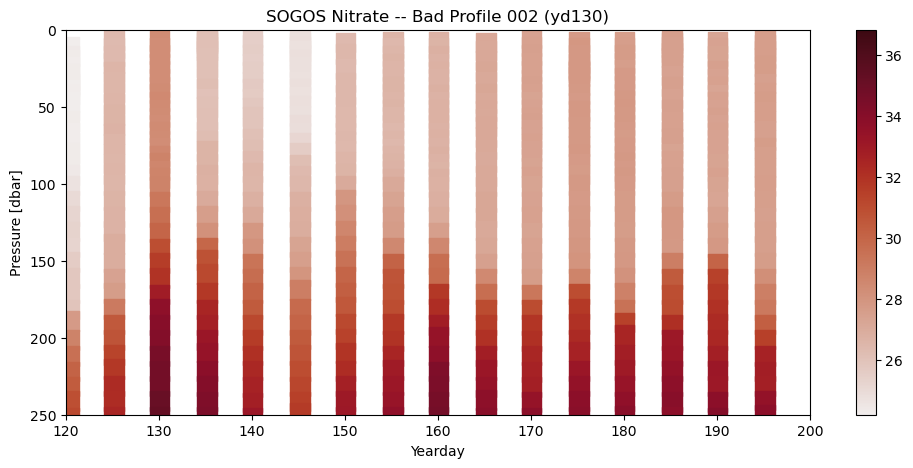

In [292]:
fig = plt.figure(figsize=(12,5))

dat = float6030[(float6030.yearday>120) & (float6030.yearday<210)]
plt.scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.amp, s=200, marker='s')
ax=plt.gca()
ax.invert_yaxis()
ax.set_title('SOGOS Nitrate -- Bad Profile 002 (yd130)')
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_ylim([250, 0])
ax.set_xlim([120,200])
plt.colorbar()


In [131]:
# df_sogos.to_csv('../working-vars/go-bgc/sogos_float_0928.csv')

# 2. Do QC on data

- Flag meanings are here: (https://argo.ucsd.edu/data/how-to-use-argo-files/)

In [11]:
# Initial Range Drop
argo_data = argo_df.copy()

# Adjust data to bounds
argo_data = argo_data[argo_data['pressure'] < 1000]
argo_data = argo_data[(argo_data['lat'] > -60) & (argo_data['lat'] < -45)]
argo_data = argo_data[(argo_data['lon'] > 5) & (argo_data['lon'] < 65)]

# cut off dates to two year before and after deployment
argo_data = argo_data[(argo_data['yearday'] > (120-365*2)) & (argo_data['yearday'] < (200+365*2))]
# argo_data.describe()

In [12]:
# Additional variable QC drop
argo_qc = argo_data.copy()
print(str(len(argo_qc)) + ' obs before QC')
X = len(argo_qc)

for var in [x for x in qcvars if x != "pH_qc"]:
    argo_qc = argo_qc[(argo_qc[var] == '1') | (argo_qc[var] == '2')| (argo_qc[var] == '8')]
    #qc flag meanings           1: good data, 2: probably good data, 8: interpolated value
    
    print('after ' + var)
    print('\t' + str(len(argo_qc)) + ' obs left   ' + ' \t' +str(X-len(argo_qc)) + ' dropped'); 
    X = len(argo_qc)

# print('Note no QC drop on pH to preserve nitrate data from SOGOS float')
# print('Keep pH as a field for now, but will not use')

# argo_qc.describe()

508410 obs before QC
after juld_qc
	508410 obs left    	0 dropped
after position_qc
	508410 obs left    	0 dropped
after pressure_qc
	508410 obs left    	0 dropped
after temperature_qc
	507660 obs left    	750 dropped
after salinity_qc
	506493 obs left    	1167 dropped
after oxygen_qc
	123967 obs left    	382526 dropped
after nitrate_qc
	49964 obs left    	74003 dropped


# 3. Restrict by space and time

In [13]:
# Methods
def print_bounds(DF):
    # print('Bounds of data: \n')
    print('Dates: \t\t' + str(sg.ytd2datetime(DF.yearday.min())) + ' to ' + str(sg.ytd2datetime(DF.yearday.max())))
    print('Latitude:\t' + str(DF.lat.min()) + ' to ' + str(DF.lat.max()))
    print('Longitude:\t' + str(DF.lon.min()) + ' to ' + str(DF.lon.max()))
    
def restrict_DF(data, start_yd, end_yd, lat1, lat2, lon1, lon2):
    data = data[(data.lat > lat1) & (data.lat < lat2)]
    data = data[(data.lon > lon1 ) & (data.lon <lon2)]
    data = data[(data.yearday > start_yd) & (data.yearday < end_yd)]
    return data


### Basic time and lat/lon box

In [14]:
# Restrict by time
start_yd = sg.datetime2ytd(np.datetime64('2017-04-20')) # datetime(2019,4,30)  # yd 120
end_yd = sg.datetime2ytd(np.datetime64('2021-07-30')) # datetime(2019,7,19)  # yd 200

# Remove some points that appear to roam outsize the ASZ
lat1 = -65; lat2 = -45
lon1 = 5; lon2 = 65
argo_qc = restrict_DF(argo_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)
# ship_qc = restrict_DF(ship_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)

print_bounds(argo_qc)
wmoids = argo_qc.wmoid.unique()
print('Number of floats within bounds: ' + str(len(argo_qc.wmoid.unique())))
# argo_qc.value_counts('wmoid')

Dates: 		2017-05-08 to 2021-07-16
Latitude:	-59.999 to -45.016
Longitude:	5.065 to 64.896
Number of floats within bounds: 18


### By fronts:

In [15]:
# Restrict the data to Antarctic Southern Zone (ASZ) region
PF = pd.read_csv('../data/ACC_fronts/PF.csv', header=None)
SIF = pd.read_csv('../data/ACC_fronts/SIF.csv', header=None)
for csv in [PF, SIF]:
    csv.columns = ['lon', 'lat']

argo_qc = dfproc.between_fronts(argo_qc, PF, SIF, buffers=[0.5,0.5])

In [16]:
# Remove any floats that have fewer than 100 obs
newdf = pd.DataFrame()
for wmo in wmoids: 
    flo = argo_qc[argo_qc.wmoid==wmo]
    if len(flo)>100:
        newdf = pd.concat([newdf, flo])
    else:
        print('wmo ' + str(wmo) + ' removed.')
argo_qc = newdf.copy()


print_bounds(argo_qc)
wmoids = argo_qc.wmoid.unique()
print('Number of floats within fronts, QC-ed: ' + str(len(argo_qc.wmoid.unique())))
argo_qc.value_counts('wmoid')

wmo 5904845 removed.
wmo 5904847 removed.
wmo 5904854 removed.
wmo 5905366 removed.
wmo 5906008 removed.
wmo 5906032 removed.
wmo 5906206 removed.
wmo 5906209 removed.
Dates: 		2017-05-08 to 2021-07-11
Latitude:	-59.566 to -49.263
Longitude:	5.3 to 64.896
Number of floats within fronts, QC-ed: 10


wmoid
5905996    3837
5906007    3725
5906030    3644
5906031    3552
5906207    2777
5904659    2698
5905135    2652
5905368    1622
5904469    1103
5906211     592
dtype: int64

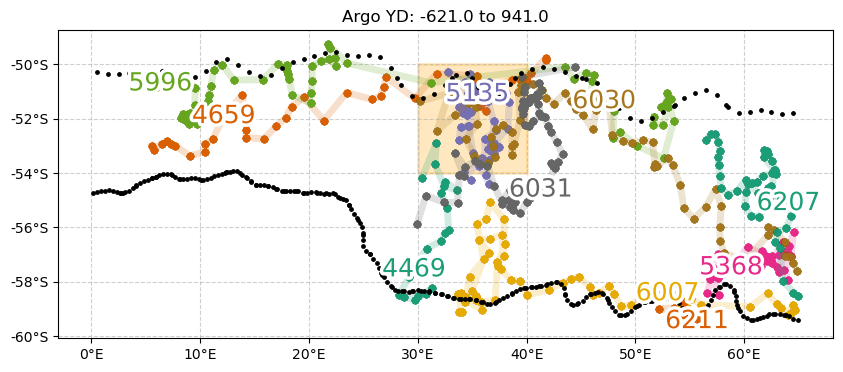

In [18]:
# After basic box restriction and QC drop

wmo_colors = dict.fromkeys(wmoids)
pal = sns.color_palette('Dark2', len(wmoids))

for i, wmo in enumerate(wmoids):
    wmo_colors[wmo] = pal[i]

fig = plt.figure(figsize=(10,4))
ax=plt.gca()

for wmo in wmoids:
    ax.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.2, linewidth=5, label=str(wmo)[3:], zorder=3)
    ax.scatter(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

# for wmo in [5906030]:
#     ax.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
#             color = wmo_colors[wmo], alpha=0.4, linewidth=7, label=str(wmo)[3:], zorder=3)
#     ax.scatter(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
#             color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)

plt.title('Argo YD: ' + str(start_yd) + ' to ' + str(end_yd))
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.25,linewidth=2, zorder=1)

for front in [SIF, PF]:
     front = front[(front.lon > 0 ) & (front.lon <65)]
     ax.scatter(front.lon, front.lat, color='k', s=6, zorder=3)
     

# ax.legend()
ax.add_patch(rect)
# ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=18, zorder=3);
# labelLines(lins) # , align=False, fontsize=18)
# plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)

In [466]:
# # Initial Range Drop -- OLD WAY. now using restrict_df()
# # argo_data = argo_df.copy()

# # # If using fronts , continue to restrict manually (jan 2024)
# start_yd = sg.datetime2ytd(np.datetime64('2017-04-20')) # datetime(2019,4,30)  # yd 120
# end_yd = sg.datetime2ytd(np.datetime64('2021-07-30')) # datetime(2019,7,19)  # yd 200
# lat1 = -65; lat2 = -45
# lon1 = 5; lon2 = 65

# argo_data = restrict_DF(argo_data, start_yd, end_yd, lat1, lat2, lon1, lon2)
# argo_data = argo_data[(argo_data['lat'] > -60) & (argo_data['lat'] < -45)]
# argo_data = argo_data[(argo_data['lon'] > 5) & (argo_data['lon'] < 65)]


# # cut off dates to two year before and after deployment
# argo_data = argo_data[(argo_data['yearday'] > (120-365*2)) & (argo_data['yearday'] < (200+365*2))]

# wmoids = argo_qc.wmoid.unique()
# print('Number of floats after box drop: ' + str(len(argo_data.wmoid.unique())))
# # argo_qc.value_counts('wmoid')
# print(argo_data.wmoid.unique())

# argo_data.describe()


Number of floats after box drop: 19
[5904469 5904658 5904659 5904845 5904847 5904854 5905135 5905366 5905368
 5905996 5906007 5906008 5906030 5906031 5906032 5906206 5906207 5906209
 5906211]


,wmoid,yearday,lat,lon,pressure,CT,SA,oxygen,nitrate,temperature,salinity,sigma0,spice
count,5.722600e+05,572260.000000,572260.000000,572260.000000,553309.000000,551222.000000,551222.000000,134461.000000,59576.000000,552478.000000,551222.000000,551222.000000,551222.000000
mean,5.905466e+06,370.142555,-52.317306,36.220592,552.749084,2.279244,34.561114,228.246735,30.187088,2.309473,34.394474,27.456555,-0.234176
std,6.137380e+02,338.212801,4.484160,17.391789,390.056519,1.400980,0.300283,56.908066,4.008195,1.398020,0.297081,0.311202,0.205398
min,5.904469e+06,-603.853947,-59.999000,5.029000,2.120000,-1.856310,33.766927,163.400513,11.140358,-1.860000,33.605274,25.982729,-1.011093
25%,5.904847e+06,180.071586,-56.800000,21.540000,242.289993,1.688097,34.330681,184.006134,27.355894,1.717000,34.166901,27.242103,-0.318846
50%,5.905368e+06,410.765289,-51.582000,36.476000,508.290009,2.215293,34.641621,203.285034,30.809956,2.253723,34.474625,27.530681,-0.188855
75%,5.906030e+06,626.121840,-48.234000,50.809000,792.340027,2.674596,34.844160,275.532227,33.641571,2.720000,34.673820,27.712566,-0.088498
max,5.906211e+06,927.803403,-45.016000,64.896000,2002.469971,10.949378,34.982857,371.921844,36.812965,10.964000,34.813339,27.857157,1.211068


In [187]:
# # Restrict by time # shouldn't need to do this but this is right, jun 2024
# start_yd = sg.datetime2ytd(np.datetime64('2017-04-20')) # datetime(2019,4,30)  # yd 120
# end_yd = sg.datetime2ytd(np.datetime64('2021-07-30')) # datetime(2019,7,19)  # yd 200

# # Remove some points that appear to roam outsize the ASZ
# lat1 = -65; lat2 = -45
# lon1 = 5; lon2 = 65
# argo_qc = restrict_DF(argo_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)
# ship_qc = restrict_DF(ship_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)

### Optional variable: Add dN/dz


In [21]:
def add_nitrate_grad(platDF):
    """
    Calculate nitrate gradient dNO3/dZ using derivative of Pchip interpolator 
    @param      platDF: dataframe with argo profiles 
    @return     list of dataframes, each dataframe is a profile with a dN/dZ column added    
    """
    new_DF = pd.DataFrame()

    # profids = pd.unique(platDF.profid) # list of profile ids
    # profile_DFs = []
    # for i in range(len(profids)):
    #     profile_DFs.append(platDF[platDF['profid'] == profids[i]].copy())

    profile_DFs = dfproc.list_profile_DFs(platDF)

    for profile in profile_DFs:

        if np.isnan(profile.nitrate).all():
            nans = np.empty(len(profile['pressure'])); nans[:] = np.NaN
            profile.loc[:, 'grad_nitrate'] = nans
        else:
            f = scipy.interpolate.PchipInterpolator(x=profile.pressure.values, y=profile.nitrate.values, extrapolate = False)
            devf = f.derivative()
            grad_nitrate = devf(profile["pressure"].values)
            # 
            
            profile.loc[:, 'grad_nitrate'] = grad_nitrate
        
        # Take vert N2 and find the maximum in the profile. 
        
        new_DF = pd.concat([new_DF, profile])

    return new_DF

In [22]:
argo_dn = add_nitrate_grad(argo_qc)
argo_dn

wmoid      profid     yearday     lat     lon    pressure  \
N_PROF N_LEVELS                                                                
120    23        5904469  5904469120 -243.341968 -59.318  20.762   36.500000   
       80        5904469  5904469120 -243.341968 -59.318  20.762  122.030006   
       86        5904469  5904469120 -243.341968 -59.318  20.762  131.809998   
       134       5904469  5904469120 -243.341968 -59.318  20.762  211.309998   
       140       5904469  5904469120 -243.341968 -59.318  20.762  220.519989   
...                  ...         ...         ...     ...     ...         ...   
15     350       5906036  5906036015  315.945683 -40.387  43.905  699.739990   
       376       5906036  5906036015  315.945683 -40.387  43.905  751.739990   
       400       5906036  5906036015  315.945683 -40.387  43.905  799.739990   
       425       5906036  5906036015  315.945683 -40.387  43.905  849.739990   
       436       5906036  5906036015  315.945683 -40.387  43.905  871.739990   

                       CT         SA      oxygen    nitrate  ...  juld_qc  \
N_PROF N_LEVELS                                              ...            
120    23        0.571653  33.986129  331.772491  26.517487  ...        1   
       80        0.093973  34.462847  259.920380  32.085560  ...        1   
       86        0.417962  34.535569  237.983017  32.666294  ...        1   
       134       1.585580  34.799827  176.802002  33.558384  ...        1   
       140       1.620556  34.807129  176.287628  33.456509  ...        1   
...                   ...        ...         ...        ...  ...      ...   
15     350       6.923342  34.642290  200.832138  25.302105  ...        1   
       376       6.423527  34.596253  205.015198  26.430208  ...        1   
       400       5.984766  34.571306  205.229340  27.519115  ...        1   
       425       5.589732  34.553402  202.114029  28.282497  ...        1   
       436       5.517976  34.565541  201.930130  28.571844  ...        1   

                 position_qc  pressure_qc  temperature_qc  salinity_qc  \
N_PROF N_LEVELS                                                          
120    23                  1            1               8            8   
       80                  1            1               8            8   
       86                  1            1               8            8   
       134                 1            1               8            8   
       140                 1            1               8            8   
...                      ...          ...             ...          ...   
15     350                 1            1               1            2   
       376                 1            1               1            2   
       400                 1            1               1            2   
       425                 1            1               1            2   
       436                 1            1               1            2   

                oxygen_qc nitrate_qc pH_qc  buoyancy grad_nitrate  
N_PROF N_LEVELS                                                    
120    23               1          1     4  0.000040     0.070235  
       80               1          1     4  0.000040     0.061362  
       86               1          1     4  0.000037     0.022951  
       134              1          1     4  0.000003     0.000000  
       140              1          1     4  0.000003    -0.010035  
...                   ...        ...   ...       ...          ...  
15     350              1          1     1  0.000011     0.028100  
       376              1          1     1  0.000008     0.022185  
       400              1          1     1  0.000009     0.018276  
       425              1          1     1  0.000008     0.013996  
       436              1          1     1  0.000008     0.012506  

[31002 rows x 25 columns]

Text(0.5, 1.0, 'Nitrate Gradient: profid 5904659100')

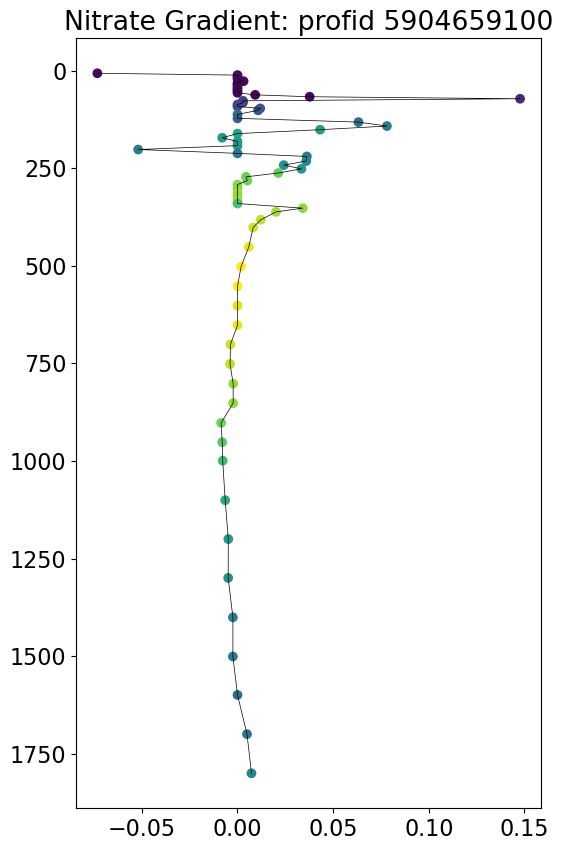

In [55]:
fig = plt.figure(figsize=(6, 10))
ax = fig.gca()

profile_DFs = list_profile_DFs(argo_dn)

prof = profile_DFs[20]

plt.scatter(prof.grad_nitrate, prof.pressure, c=prof.nitrate, cmap='viridis')
plt.plot(prof.grad_nitrate, prof.pressure, c='k', linewidth=0.5)
ax.invert_yaxis()
ax.set_title('Nitrate Gradient: profid ' + list(prof.profid)[1])

### Optional variable (outdated): Add distance to max buoyancy depth

In [20]:
## Add distance to maximum buoyancy depth
argo_dist2maxb = dfproc.add_dist2maxb(argo_dn)

AttributeError: 'DataFrame' object has no attribute 'buoyancy'

# 4. Add calculated variables

- Oxygen percent saturation / AOU
- Density gradient drho/dz
- Distance from the depth of maximum buoyancy frequency

In [19]:
# Add buoyancy to each profile
argo_qc = dfproc.add_Pchip_buoyancy(argo_qc) 
argo_qc['log_buoyancy'] = np.log(argo_qc['buoyancy'])

# Add oxygen metrics, oxygen saturation, 
argo_qc['AOU'] = gsw.O2sol(argo_qc['SA'], argo_qc['CT'], argo_qc['pressure'], argo_qc['lon'], argo_qc['lat']) - argo_qc['oxygen']
argo_qc['o2sat'] = gsw.O2sol(argo_qc['SA'], argo_qc['CT'], argo_qc['pressure'], argo_qc['lon'], argo_qc['lat'])
len(argo_qc)

/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


26202

In [43]:
def add_yd_sinusoids(DF):
    DF = DF.copy()
    DF['ydcos'] = [sg.get_ydsines(x)[0] for x in DF.yearday.values]
    DF['ydsin'] = [sg.get_ydsines(x)[1] for x in DF.yearday.values]
    return DF

argo_qc = add_yd_sinusoids(argo_qc)

### Make argo_final

In [54]:
# Select valid WMOIDs to use
valid_wmoids = [5904469, 5904659, 5905368, 5905996, 5906030, 5906031, 5906207]
argo_final = argo_qc[argo_qc.wmoid.isin(valid_wmoids)]
wmoids = argo_final.wmoid.unique()

# Reorder variables: 
finalvars = ['wmoid', 'profid', 'yearday', 'lat', 'lon', 'pressure', 'CT', 'SA',
       'nitrate', 'oxygen', 'AOU', 'o2sat',
       'sigma0', 'spice', 'buoyancy', 'log_buoyancy', 'temperature', 'salinity',
       'ydcos', 'ydsin',
       'juld_qc', 'position_qc', 'pressure_qc', 'temperature_qc',
       'salinity_qc', 'nitrate_qc', 'oxygen_qc',
       ]
argo_final = argo_final[finalvars].dropna()

# Reset wmoids
wmoids = argo_final.wmoid.unique()

# print('# Ship observations (without NaNs): \t', shipDF.shape[0])
print('# Float observations (without NaNs ): \t', argo_final.shape[0])
print('# 5906030 observations (without NaNs): \t', argo_final[argo_final.wmoid==5906030].shape[0])

print(); print_bounds(argo_final)
print(); print('WMO    ' + '\t # obs')
print(argo_final.wmoid.value_counts())

# Float observations (without NaNs ): 	 17645
# 5906030 observations (without NaNs): 	 3308

Dates: 		2017-05-08 to 2021-07-11
Latitude:	-58.682 to -49.263
Longitude:	5.3 to 64.896

WMO    	 # obs
5905996    3487
5906030    3308
5906031    3257
5904659    2544
5906207    2520
5905368    1488
5904469    1041
Name: wmoid, dtype: int64


/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 6 in `xvals` is outside the range of its associated line (xmin=56.495, xmax=64.896, xval=21.871779922129324). Clipping it into the allowed range.
  warnings.warn(


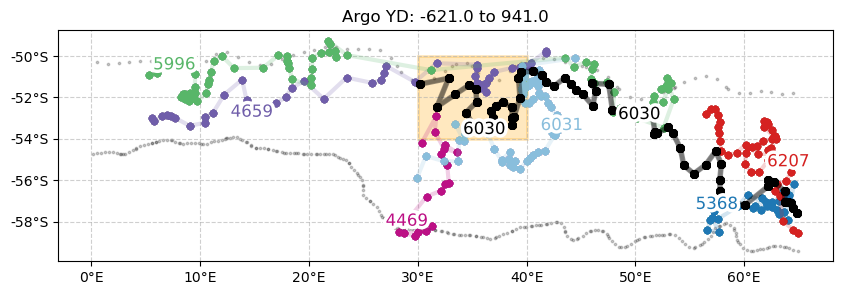

In [55]:
# After all drops:

from mod_plot import wmo_colors
# wmo_colors = dict.fromkeys(wmoids)
# pal = sns.color_palette('Dark2', len(wmoids))
# for i, wmo in enumerate(wmoids):
#     wmo_colors[wmo] = pal[i]

fig = plt.figure(figsize=(10,3))
ax=plt.gca()

for wmo in wmoids:
    ax.plot(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.2, linewidth=3, label=str(wmo)[3:], zorder=3)
    ax.scatter(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.4, linewidth=4, label=str(wmo)[3:], zorder=3)
    ax.scatter(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)

plt.title('Argo YD: ' + str(start_yd) + ' to ' + str(end_yd))
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.25,linewidth=2, zorder=1)

for front in [SIF, PF]:
     front = front[(front.lon > 0 ) & (front.lon <65)]
     ax.scatter(front.lon, front.lat, color='k', s=3, alpha=0.2, zorder=1)
     

# ax.legend()
ax.add_patch(rect)
# ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=12, zorder=3);

In [51]:
argo_final.reset_index()

,N_PROF,N_LEVELS,wmoid,profid,yearday,lat,lon,pressure,CT,SA,...,log_buoyancy,temperature,salinity,juld_qc,position_qc,pressure_qc,temperature_qc,salinity_qc,nitrate_qc,oxygen_qc
0,85,10,5904469,5904469085,-603.853947,-54.200,30.351,17.540001,1.853910,34.127808,...,-17.798697,1.850000,33.965027,1,1,1,8,8,1,1
1,85,13,5904469,5904469085,-603.853947,-54.200,30.351,22.119999,1.852919,34.127803,...,-15.947195,1.849237,33.965023,1,1,1,8,8,1,1
2,85,20,5904469,5904469085,-603.853947,-54.200,30.351,31.469999,1.853216,34.127822,...,-17.854724,1.850000,33.965019,1,1,1,8,8,1,1
3,85,22,5904469,5904469085,-603.853947,-54.200,30.351,33.329998,1.853123,34.127827,...,-16.504050,1.850000,33.965019,1,1,1,8,8,1,1
4,85,31,5904469,5904469085,-603.853947,-54.200,30.351,45.660000,1.852509,34.127389,...,-14.547193,1.850000,33.964516,1,1,1,8,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17640,48,428,5906207,5906207048,873.260116,-58.399,64.473,752.199951,2.254218,34.794035,...,-12.344345,2.300000,34.624870,1,1,1,8,8,1,1
17641,48,454,5906207,5906207048,873.260116,-58.399,64.473,802.299988,2.227968,34.816213,...,-12.584622,2.277150,34.646877,1,1,1,8,8,1,1
17642,48,480,5906207,5906207048,873.260116,-58.399,64.473,852.519958,2.220279,34.834315,...,-13.024981,2.273000,34.664837,1,1,1,8,8,1,1
17643,48,506,5906207,5906207048,873.260116,-58.399,64.473,902.429993,2.208826,34.844450,...,-13.147390,2.265000,34.674870,1,1,1,8,8,1,1


# 5. Save argo_final

In [56]:
save = False
if save:
    argo_final.to_csv('../data/bgc-argo/argoDF_qc_jun24.csv')

In [ ]:
# # Choose final features to be tested (outdated jun 2018, keep all QC columns for data
# tvars = ['yearday','lat','lon','pressure', 'CT', 'SA','oxygen', 'sigma0', 'buoyancy', 'log_buoyancy', 
#          'spice','o2sat', 'ydcos', 'ydsin', 'temperature', 'salinity']
# pvars = ['nitrate']  # prediction variable
# Take variables of interest
# argo_final = argo_final[['wmoid', 'profid'] + tvars + pvars].dropna()
# shipDF = shipDF[tvars + pvars + ['profid', 'dist_maxb']].dropna() # dont drop on wmoid yet


- Ensured same as input to RandomForest.ipynb , June 2024 ('../data/bgc-argo/floatDF_qc_jun24.csv')
- However, there are a few differences in float 6207. Negligible differences

# 6. Check with old argo split2023 version.

- Difference in just five obsevations from float 6207

In [754]:
from mod_main import floatDF as oldargo
# pd.read_csv('/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/working-vars/RF-training/mldata_floatDF_split2023.csv', index_col=0)

In [563]:
dir = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/RF-training/'
temp = pd.read_csv(dir + 'mldata_floatDF_split2023.csv')
temp[temp.wmoid==5906207].CT.min()

0.7650275611742898

In [765]:
argo_final.columns

Index(['yearday', 'lat', 'lon', 'pressure', 'CT', 'SA', 'oxygen', 'sigma0',
       'log_buoyancy', 'spice', 'o2sat', 'ydcos', 'ydsin', 'nitrate', 'wmoid',
       'profid'],
      dtype='object')

In [764]:
dir = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/RF-training/'
temp = pd.read_csv(dir + 'mldata_floatDF_split2023.csv')
print(temp[temp.wmoid==5906207].SA.min())


dir = '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/RF-training/'
temp = pd.read_csv(dir + 'mldata_floatDF_fin24.csv')
print(temp[temp.wmoid==5906207].SA.min())

print(oldargo[oldargo.wmoid==5906207].SA.min())

print(argo_final[argo_final.wmoid==5906207].SA.min())


34.042634012863026
34.042634012863026
34.042634012863026
34.023935728089576


[text](../../SOGOS-ML/working-vars/RF-training/mldata_floatDF_split2023.csv)

In [757]:
argo_final[argo_final.wmoid==5906207].CT.min()

0.7642220969401388

In [758]:
temp.value_counts('wmoid')

wmoid
5905996    3486
5906030    3308
5906031    3256
5904659    2544
5906207    2521
5905368    1488
5904469    1041
dtype: int64

In [540]:
oldargo.value_counts('wmoid')

wmoid
5905996    3486
5906030    3308
5906031    3256
5904659    2544
5906207    2521
5905368    1488
5904469    1041
dtype: int64

In [523]:
oldargo.describe()

,yearday,lat,lon,pressure,CT,SA,oxygen,sigma0,log_buoyancy,spice,o2sat,mncos,mnsin,month,nitrate,wmoid,profid,dist_maxb,ydcos,ydsin
count,17644.000000,17644.000000,17644.000000,17644.000000,17644.000000,17644.000000,17644.000000,17644.000000,17644.000000,17644.000000,17644.000000,1.764400e+04,1.764400e+04,17644.000000,17644.000000,1.764400e+04,1.764400e+04,17644.000000,17644.000000,17644.000000
mean,261.387147,-53.291824,40.735773,302.109762,1.914370,34.395861,250.484252,27.361793,-12.408210,-0.390839,333.413492,-9.212918e-02,2.448272e-02,6.317955,31.382708,5.905703e+06,5.905703e+09,-156.890386,-0.069328,0.058004
std,376.483538,2.375560,16.990384,254.072176,0.787082,0.294478,64.690164,0.241948,1.637847,0.217146,6.748141,7.088077e-01,6.989711e-01,3.274049,3.411854,5.913006e+02,5.912780e+05,258.518503,0.708511,0.699927
min,-603.853947,-58.682000,5.300000,4.250000,-1.818182,33.861920,163.400510,26.719520,-21.980751,-0.949835,309.617113,-1.000000e+00,-1.000000e+00,1.000000,22.101385,5.904469e+06,5.904469e+09,-988.010000,-1.000000,-0.999953
25%,21.056042,-54.963000,31.563000,101.857501,1.525121,34.108749,184.607028,27.179233,-13.014580,-0.588256,329.768549,-8.660254e-01,-5.000000e-01,4.000000,28.478008,5.905368e+06,5.905368e+09,-250.000000,-0.771960,-0.640736
50%,296.140347,-52.863000,40.406000,239.495005,2.019862,34.376257,237.018250,27.357906,-12.030194,-0.412367,332.048424,-1.836970e-16,1.224647e-16,6.000000,32.219065,5.906030e+06,5.906030e+09,-90.000000,-0.162929,0.125642
75%,565.527002,-51.304000,57.350000,381.460000,2.268750,34.659575,321.293498,27.564177,-11.383183,-0.195353,336.740493,5.000000e-01,5.000000e-01,9.000000,34.495955,5.906031e+06,5.906031e+09,30.510000,0.637714,0.751334
max,922.671736,-49.263000,64.896000,999.990000,5.074960,34.923669,360.653050,27.823765,-8.443500,-0.003233,367.842194,1.000000e+00,1.000000e+00,12.000000,36.472710,5.906207e+06,5.906207e+09,325.670000,0.999986,1.000000


In [524]:
argo_final.describe()

,yearday,lat,lon,pressure,CT,SA,oxygen,sigma0,log_buoyancy,spice,o2sat,ydcos,ydsin,nitrate,wmoid
count,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,17642.000000,1.764200e+04
mean,261.354416,-53.291879,40.733401,302.131561,1.914387,34.393486,250.513428,27.359900,-12.407927,-0.392504,333.419532,-0.069207,0.058013,31.390404,5.905703e+06
std,376.492386,2.375698,16.989884,254.078964,0.787143,0.294926,64.701530,0.242354,1.637898,0.217378,6.747956,0.708457,0.699993,3.412048,5.913098e+02
min,-603.853947,-58.682000,5.300000,4.250000,-1.818182,33.861920,163.400513,26.719520,-22.472500,-0.949835,309.617113,-1.000000,-0.999953,22.101385,5.904469e+06
25%,21.056042,-54.963000,31.563000,101.860001,1.525013,34.105637,184.611492,27.176279,-13.014612,-0.589808,329.776148,-0.771960,-0.640736,28.489530,5.905368e+06
50%,296.140347,-52.863000,40.406000,239.539993,2.019910,34.373512,237.018250,27.355231,-12.030118,-0.413410,332.052698,-0.162929,0.125642,32.227152,5.906030e+06
75%,565.527002,-51.304000,57.350000,381.459991,2.268876,34.658214,321.409142,27.563083,-11.383243,-0.196200,336.741521,0.637714,0.751334,34.505750,5.906031e+06
max,922.671736,-49.263000,64.896000,999.989990,5.074960,34.923669,360.653046,27.823765,-8.443849,-0.003233,367.842194,0.999986,1.000000,36.472710,5.906207e+06


In [405]:
wmoids

array([5904469, 5904659, 5905368, 5905996, 5906030, 5906031, 5906207])

(0.0, 100.0)

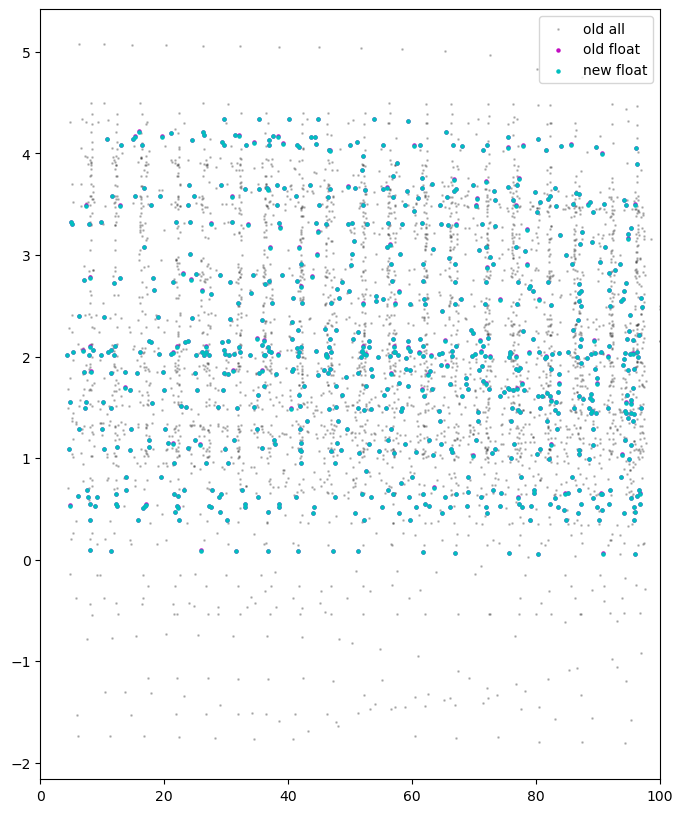

In [770]:
id = 5906030
old = oldargo #[oldargo.wmoid==5906031]
old_id = oldargo[oldargo.wmoid==id].reset_index()
float_id = argo_final[argo_final.wmoid==id].reset_index()

# lens_new = [len(x) for x in sg.list_profile_DFs(float_id)]
# lens_old = [len(x) for x in sg.list_profile_DFs(old_id)]
# lendf = pd.DataFrame({'old':lens_old, 'new':lens_new})
# lendf['diff'] = lendf['old'] - lendf['new']
# lendf

# See if any diff
fig = plt.figure(figsize=(8,10))
ax = fig.gca()

plt.scatter(old.pressure, old.CT, c='k', alpha=0.2, s=1, label='old all')
plt.scatter(old_id.pressure, old_id.CT, c='m', alpha=0.9, s=5, label='old float')
plt.scatter(float_id.pressure, float_id.CT, c='c', s=5, label='new float') 

plt.legend()

plt.xlim([0,100])
# plt.ylim([])

In [377]:
# float6027 = argo_final[argo_final.wmoid==5906207].reset_index()

# GOT VERY CLOSe, ABOVE

In [361]:
wmo_colors

{5904469: (0.735840061514802, 0.06196078431372548, 0.5225682429834679),
 5904659: (0.440722798923491, 0.36772010765090346, 0.6653902345251825),
 5905368: (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 5905996: (0.3454056132256824, 0.7150173010380623, 0.41078046905036525),
 5906030: 'k',
 5906031: (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 5906207: (0.8370472895040368, 0.13394848135332565, 0.13079584775086506),
 5906007: (0.9898808150711266, 0.40955017301038066, 0.19432525951557092)}

/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=28.246, xmax=33.568, xval=27.35). Clipping it into the allowed range.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 5 in `xvals` is outside the range of its associated line (xmin=56.495, xmax=64.896, xval=50.3). Clipping it into the allowed range.
  warnings.warn(


[Text(33.035799999999995, -54.56375793103449, '4469'),
 Text(19.7, -51.28370484581498, '4659'),
 Text(57.949999999999996, -57.745145658263304, '5368'),
 Text(12.05, -50.02546840148699, '5996'),
 Text(42.65, -53.67274108818011, '6031'),
 Text(64.0559, -55.10580084507042, '6207'),
 Text(35.0, -51.49638009049774, '6030')]

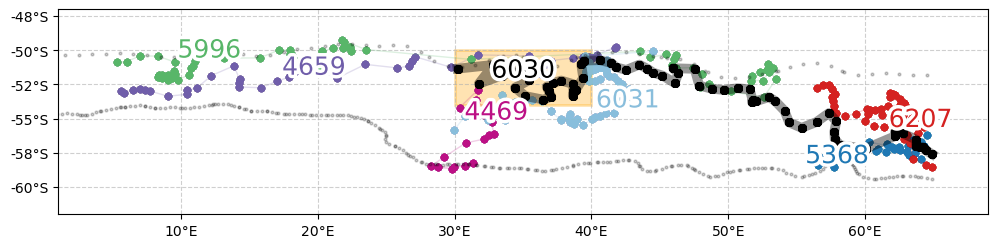

In [363]:
from mod_plot import wmo_colors
fig = plt.figure(figsize=(12,3))
ax=plt.gca()

for wmo in wmoids[wmoids!=5906030]:
    ax.plot(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.2, linewidth=1, label=str(wmo)[3:], zorder=3)
    ax.scatter(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.4, linewidth=7, label=str(wmo)[3:], zorder=3)
    ax.scatter(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)

for front in [SIF, PF]:
     front = front[(front.lon > 0 ) & (front.lon <65)]
     ax.scatter(front.lon, front.lat, color='k', alpha=0.2, s=4, zorder=3)
#      ax.plot(front.lon, front.lat, color='k', alpha=0.1, linewidth=2, zorder=3)

# plt.title('BGC-Argo Training Data')
# plt.title('Argo Yeardays: ' + str(start_yd) + ' to ' + str(end_yd))
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.3,linewidth=2, zorder=1)

ax.set_xlim(1,69)
ax.set_ylim(-62,-47)
ax.set_aspect('equal')

# ax.legend()
ax.add_patch(rect)
# ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=18, zorder=3)
# labelLines(lins) # , align=False, fontsize=18)
# plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)

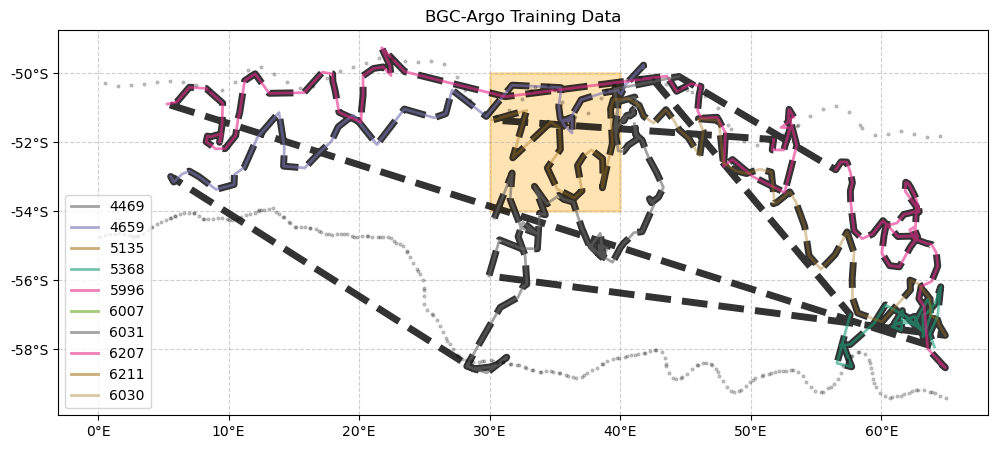

In [243]:
# Reference: Full matchup map for floats

fig = plt.figure(figsize=(12,5))
ax=plt.gca()

for wmo in wmoids[wmoids!=5906030]:
    ax.plot(argo_temp[argo_temp.wmoid==wmo].lon,argo_temp[argo_temp.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.6, linewidth=2, label=str(wmo)[3:], zorder=3)
#     ax.scatter(argo_temp[argo_temp.wmoid==wmo].lon,argo_temp[argo_temp.wmoid==wmo].lat,
#             color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(argo_temp[argo_temp.wmoid==wmo].lon,argo_temp[argo_temp.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.4, linewidth=2, label=str(wmo)[3:], zorder=3)
#     ax.scatter(argo_temp[argo_temp.wmoid==wmo].lon,argo_temp[argo_temp.wmoid==wmo].lat,
#             color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)
    
lines = ax.get_lines()
# labelLines(lines, align=False, fontsize=18, zorder=3)
# labelLines(lines, align=False, fontsize=18, zorder=3)
ax.legend()

for front in [SIF, PF]:
     front = front[(front.lon > 0 ) & (front.lon <65)]
     ax.scatter(front.lon, front.lat, color='k', alpha=0.2, s=4, zorder=3)
#      ax.plot(front.lon, front.lat, color='k', alpha=0.1, linewidth=2, zorder=3)




plt.title('BGC-Argo Training Data')
# plt.title('Argo Yeardays: ' + str(start_yd) + ' to ' + str(end_yd))
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.3,linewidth=2, zorder=1)

# ax.legend()
ax.add_patch(rect)
# ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

# labelLines(lins) # , align=False, fontsize=18)
plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)



/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=28.246, xmax=33.568, xval=27.125). Clipping it into the allowed range.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 6 in `xvals` is outside the range of its associated line (xmin=56.495, xmax=64.896, xval=50.75). Clipping it into the allowed range.
  warnings.warn(


[Text(33.035799999999995, -54.56375793103449, '4469'),
 Text(19.25, -51.29794434782609, '4659'),
 Text(58.625, -57.519767507002804, '5368'),
 Text(11.375, -50.18168539325843, '5996'),
 Text(42.875, -51.309829676071054, '6030'),
 Text(35.0, -53.618233223322335, '6031'),
 Text(64.0559, -55.10580084507042, '6207')]

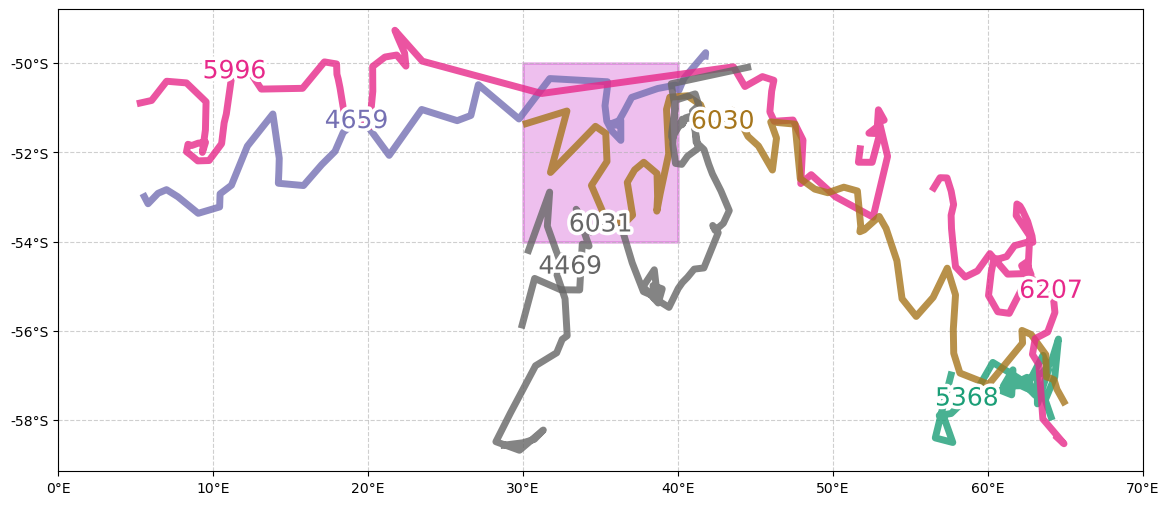

In [242]:
# Reference: Full matchup map for floats, so we can see where the  floats are
fig = plt.figure(figsize=(14,6))
ax=plt.gca()

for wmo in pd.unique(argo_temp.wmoid):
    ax.plot(argo_temp[argo_temp.wmoid==wmo].lon,argo_temp[argo_temp.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.8, linewidth=5, label=str(wmo)[3:], zorder=3)
    
# plt.title('SOGOS BGC-Argo Matchups, no temp drop (2017-2021)')
rect = patch.Rectangle((30,-54),10,4, fill=True, color="m", alpha=0.25,linewidth=2, zorder=1)

ax.add_patch(rect)
ax.set_xlim(0,70)

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=18, zorder=3)


In [ ]:
valid_wmoids = [5904469, 5904659, 5905368, 5905996, 5906030, 5906031, 5906207]
argo_temp = argo_qc[argo_qc.wmoid.isin(valid_wmoids)]

# 2.0 Figures: Float Dataset Exploration

## 2.1 Plot Float Maps

In [46]:
# Set up color palettes for plotting
size = 22
params = {'legend.fontsize': size-4, 
          'xtick.labelsize':size, 
          'ytick.labelsize':size, 
          'font.size':size,
          'font.family':'Futura'}
plt.rcParams.update(params)

# Set up WMO colors
pal = sns.color_palette("Paired", 30)
wmo_colors = dict.fromkeys(wmoids)
for i, wmo in enumerate(wmoids):
    wmo_colors[wmo] = pal[i]
wmo_colors[5906030]=sns.color_palette("Reds")[5]


varmin = -1.951301e-06
varmax = 1.130347e-04

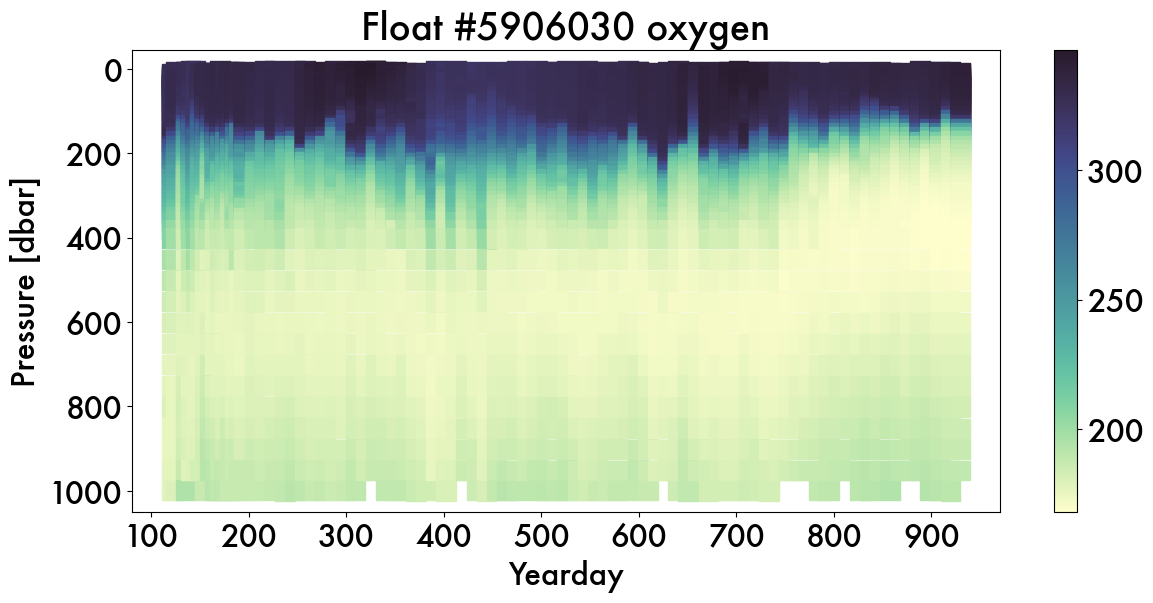

In [41]:
# PLOT: single float variable profiles

wmo = 5906030
dat = argo_qc[argo_qc.wmoid==wmo]
var = 'oxygen'

fig = plt.figure(figsize=(14,6))
plt.scatter(dat.yearday, dat.pressure, c=dat[var], cmap=cmo.deep, s=200, marker='s') #, vmin=varmin, vmax=varmax)
ax=plt.gca()
ax.invert_yaxis()

ax.set_title('Float #' + str(wmo) + ' ' + var)
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
plt.colorbar()


# fig = plt.figure(figsize=(12,5))
# plt.scatter(dat.yearday[180:340], dat.pressure[180:340], c=dat.oxygen[180:340], cmap=cmo.amp, s=200, marker='s')
# ax=plt.gca()
# ax.invert_yaxis()
# ax.set_title('BGC-Argo Float #5906030')
# ax.set_ylabel('Pressure [dbar]')
# ax.set_xlabel('Yearday')




IndexError: index 12 is out of bounds for axis 0 with size 12

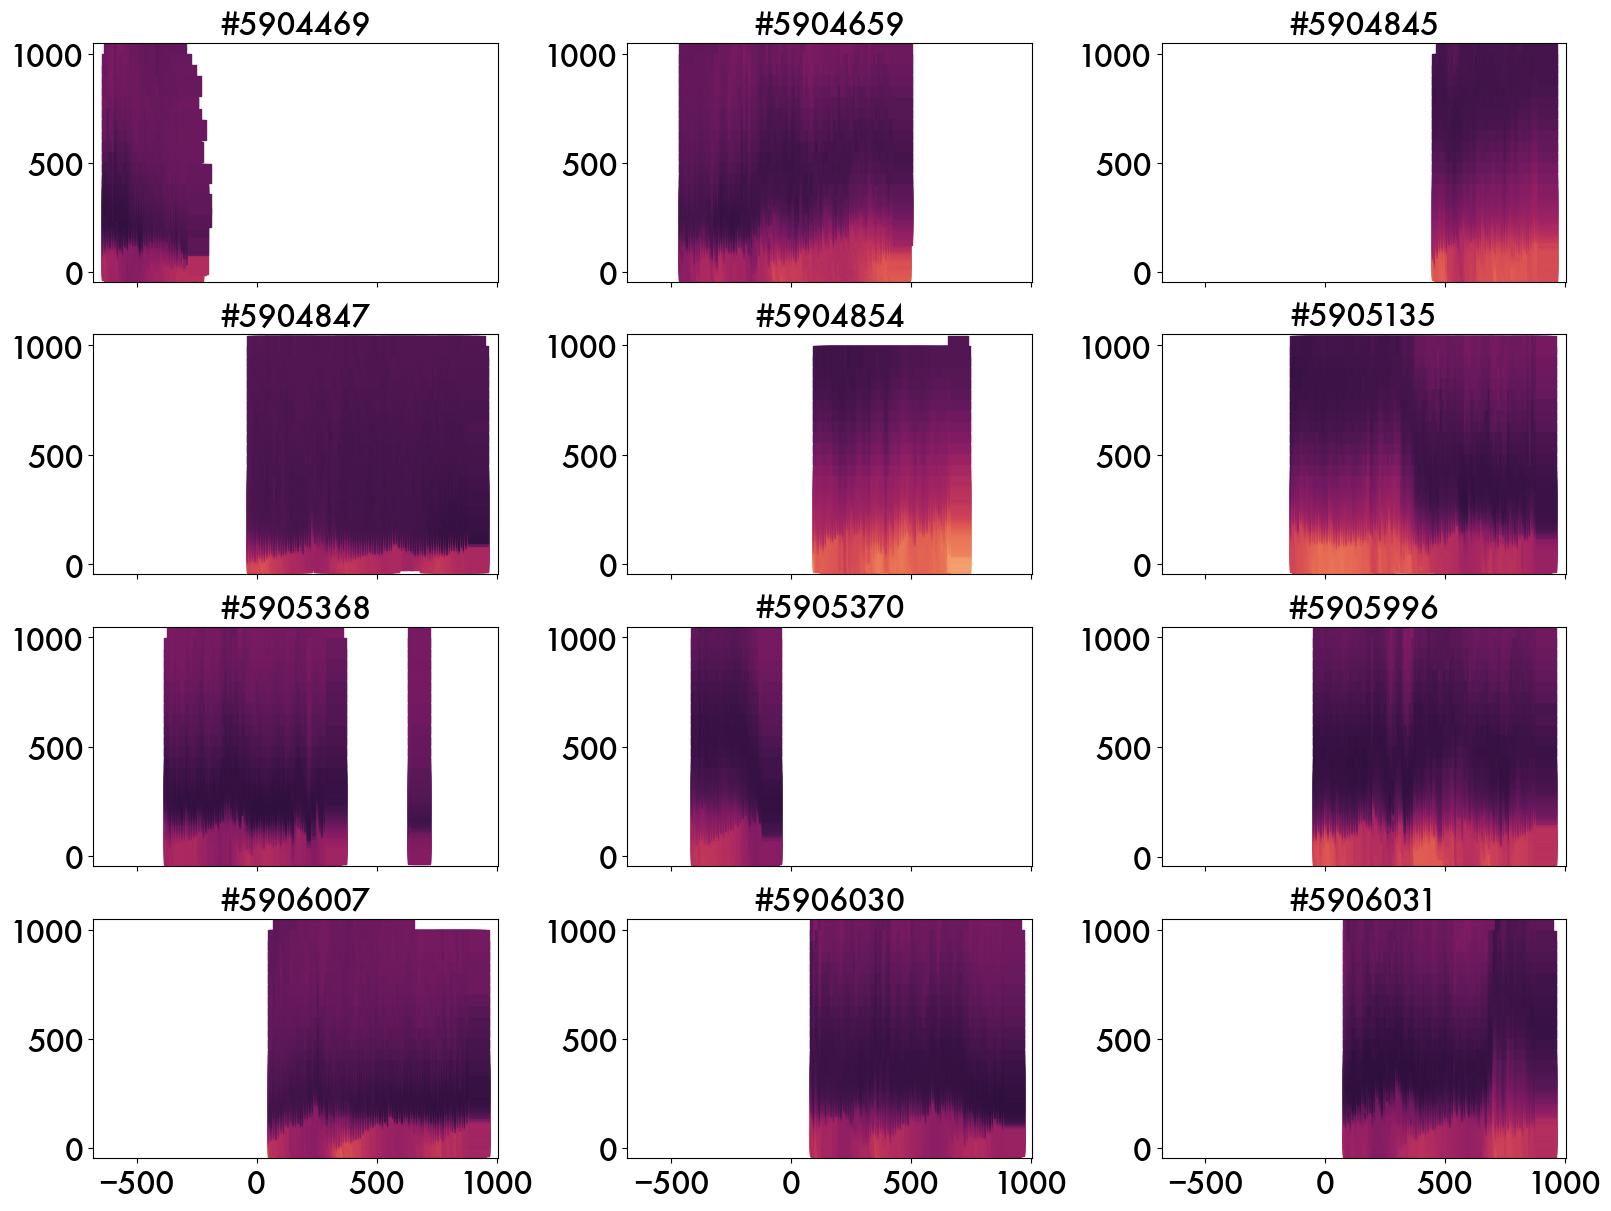

In [42]:
fig, axes = plt.subplots(4,3, figsize=(16,12), sharex=True, constrained_layout=True)
axs = axes.flatten()

for ind, wmo in enumerate(wmoids):
    dat = argo_qc[argo_qc.wmoid==wmo]

    sca = axs[ind].scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.matter, s=200, vmin=12, vmax=36, marker='s')
    axs[ind].set_title('#' + str(wmo), fontsize=22)

for ax in axs:
    ax.invert_yaxis()

fig.colorbar(sca, ax=axes[:,2], shrink=0.5).set_label('Nitrate (umol/kg)')
# plt.colorbar()
# axs[2].invert_yaxis()
# ax.set_ylabel('Pressure [dbar]')
# axs[-1].set_xlabel('Yearday')

# axes[0,:].set_title('Nitrate profiles across floats')


# 3.0 Float Selection

- Explore why float distributions do not match with glider distributions
- Notice higher temp and salinity

## Consider time coverage and temperature.

Text(0.5, 0, 'Yearday (0 = Jan 1 2019)')

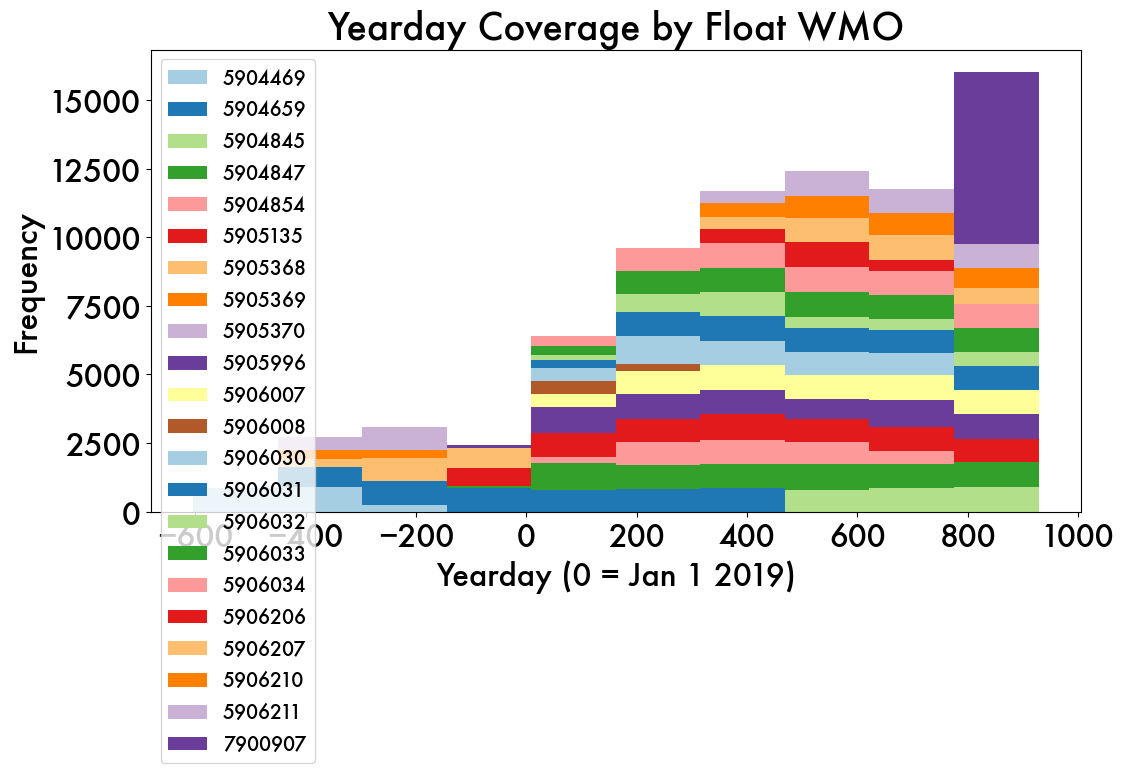

In [64]:
# argo_qc.pivot(columns='wmoid').yearday.plot(kind = 'hist', stacked=True)
pal = sns.color_palette("Paired")
sns.set_palette(pal)

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
pd.DataFrame({k: v for k, v in argo_qc.groupby('wmoid').yearday}).plot.hist(stacked=True, ax=ax) 
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Yearday Coverage by Float WMO')
ax.set_xlabel('Yearday (0 = Jan 1 2019)')

- 7900907 removed for yearday (late time coverage)

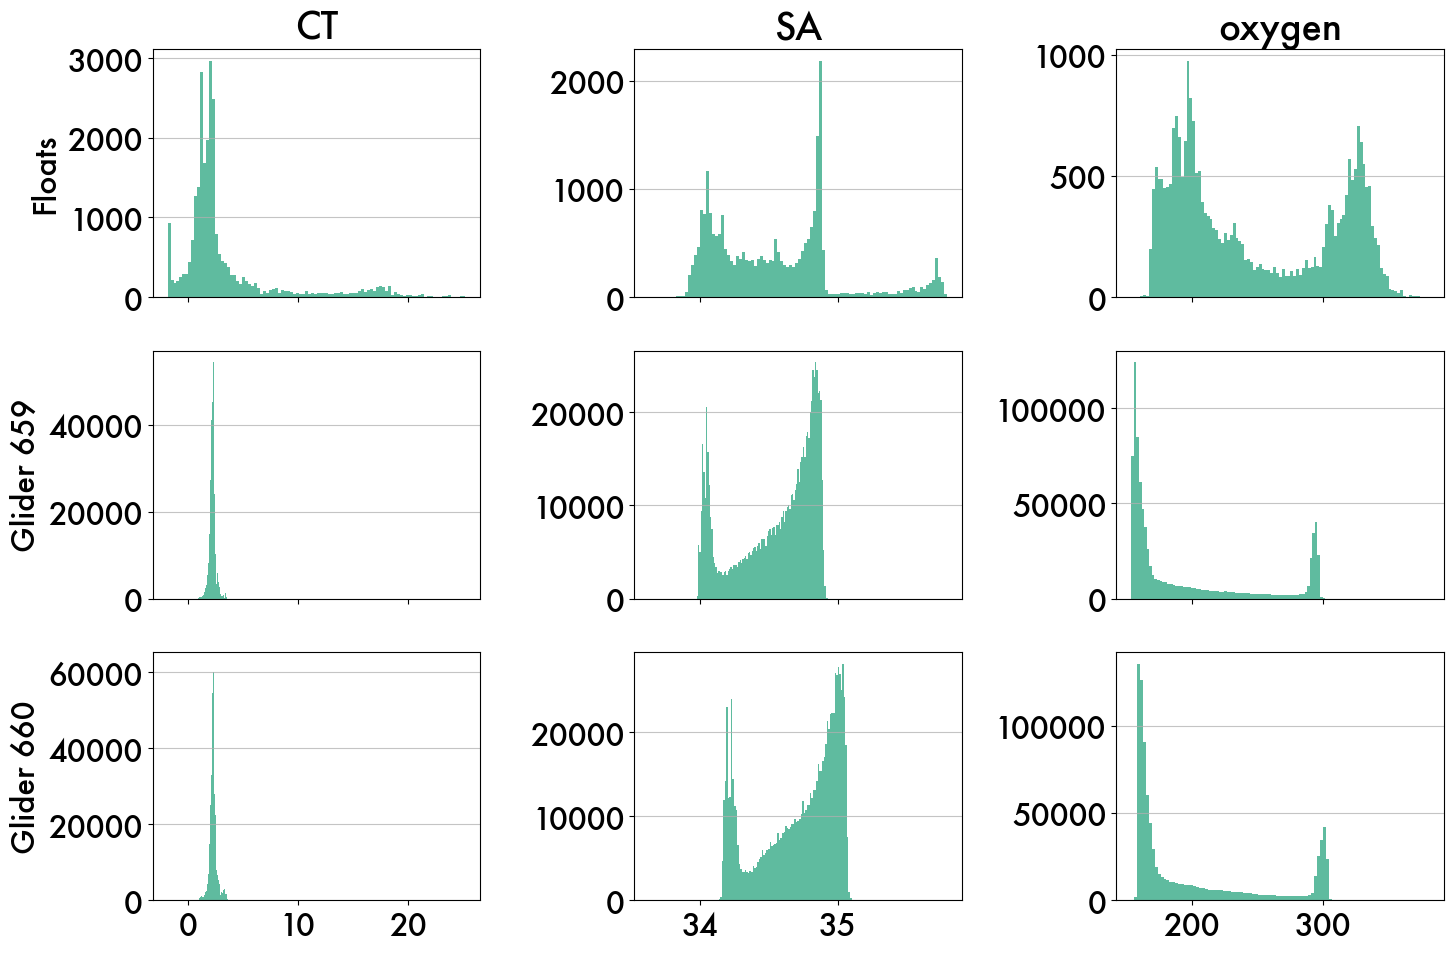

In [65]:
# Variable distributions from training ship/float data before dropping floats
nbins = 100
fig, axs = plt.subplots(3, 3, figsize=(15, 10), tight_layout=True, sharex='col')
for c, var in enumerate(['CT', 'SA', 'oxygen']):
    axs[0,c].hist(x=argo_qc[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Floats')
axs[1,0].set_ylabel('Glider 659')
axs[2,0].set_ylabel('Glider 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)

## Explore out-of range ("bad") temperatures

In [65]:
# Determine which wmo floats have high temperatures
hightemp = argo_qc[argo_qc.CT>5]
hightemp.describe()
hightemp.wmoid.value_counts()

# hightemp.yearday.describe()

5904854    1651
5906032    1367
5905135     614
5904845     481
5906206     229
5905996     154
5904659     139
5906031      79
Name: wmoid, dtype: int64

[Text(44.0, -49.142371495327104, '4659'),
 Text(28.0, -47.51544444444444, '4845'),
 Text(12.0, -47.838137719969396, '4854'),
 Text(20.0, -47.273302917442585, '5135'),
 Text(52.0, -53.34560240963855, '5996'),
 Text(36.0, -53.69079005524862, '6031'),
 Text(68.0, -45.42083349900596, '6032'),
 Text(60.0, -48.667463687150835, '6206')]

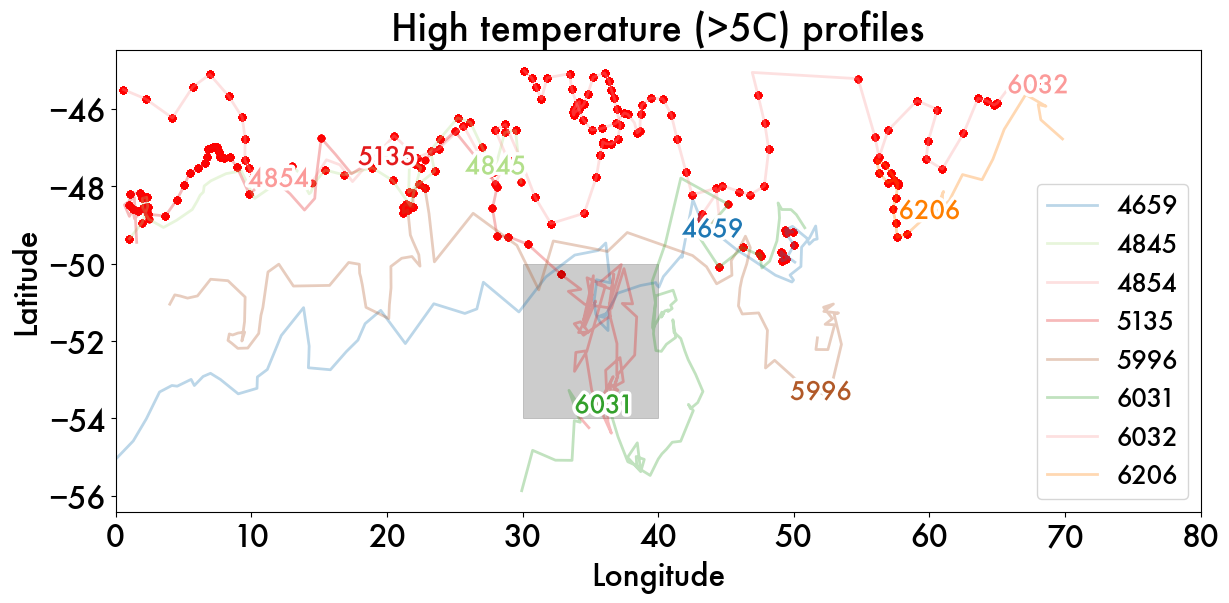

In [66]:
# PLOT: Show high temps as red points on surface lat/lon map
fig = plt.figure(figsize=(14,6))
pal = sns.color_palette("Paired")
sns.set_palette(pal)

# for wmo in pd.unique(argo_qc.wmoid):
for wmo in pd.unique(hightemp.wmoid):
    plt.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat, label=str(wmo)[3:], 
                        color=wmo_colors[wmo], linewidth=2, alpha=0.3)
for wmo in (pd.unique(hightemp.wmoid)):
    # plt.scatter(hightemp[hightemp.wmoid==wmo].lon,hightemp[hightemp.wmoid==wmo].lat, color=wmo_colors[wmo], s=20)
    plt.scatter(hightemp[hightemp.wmoid==wmo].lon,hightemp[hightemp.wmoid==wmo].lat, c='r', s=20)

plt.legend()
plt.title('High temperature (>5C) profiles')
rect = patch.Rectangle((30,-54),10,4,fill=True,color="k", alpha=0.2,linewidth=0.6)

ax=plt.gca()
ax.add_patch(rect)
ax.set_xlim(0,80)
ax.set_xlabel('Longitude')
# ax.set_ylim(-60,-30)
ax.set_ylabel('Latitude')

labelLines(ax.get_lines(), align=False, fontsize=18)

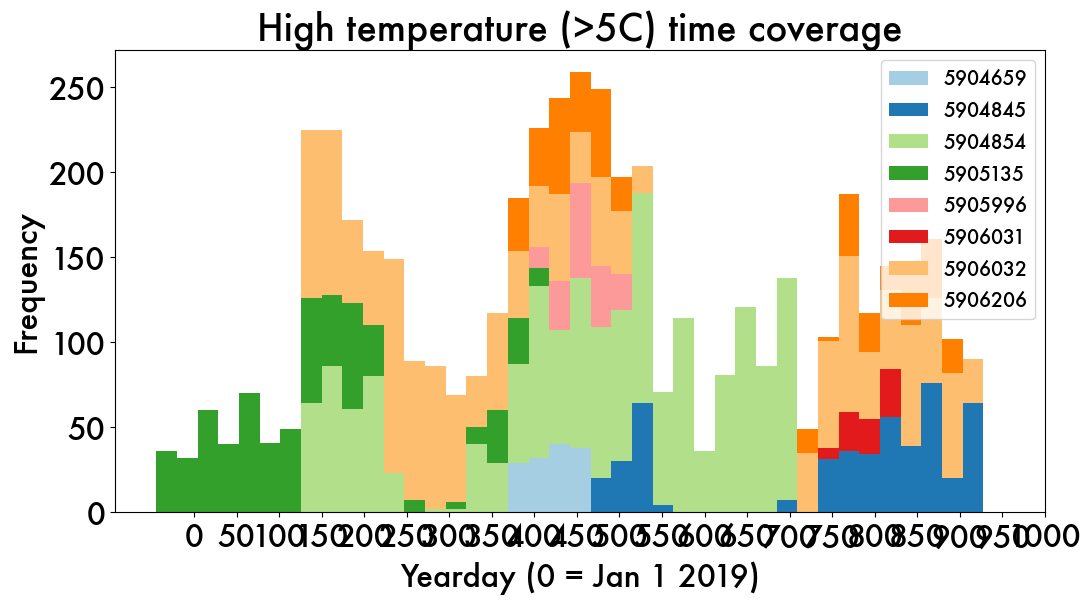

In [48]:
# PLOT: Show time coverage of bad temperature data
pal = sns.color_palette("Paired")
sns.set_palette(pal)

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
pd.DataFrame({k: v for k, v in hightemp.groupby('wmoid').yearday}).plot.hist(stacked=True, ax=ax, bins=40) 
ax.legend(loc='upper right', fontsize=14)
ax.set_title('High temperature (>5C) time coverage')
ax.set_xlabel('Yearday (0 = Jan 1 2019)')
ax.set_xticks(np.arange(00,1001,50))


Text(0.5, 0, 'Yearday')

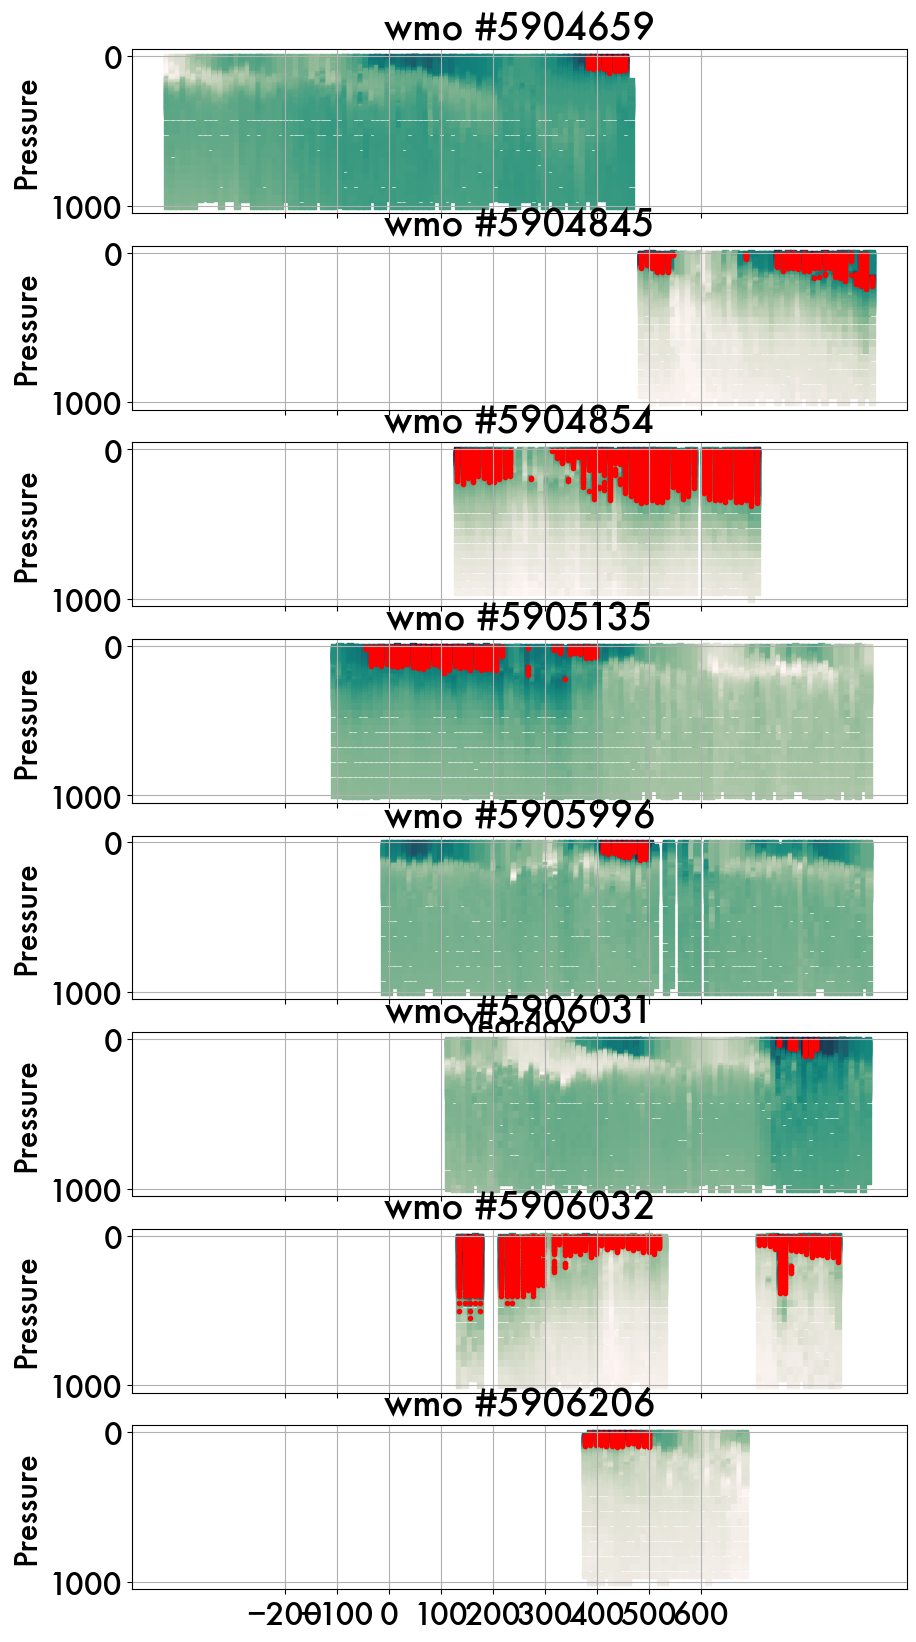

In [70]:
# PLOT: Show where bad temps are in profile
fig, axs = plt.subplots(8,1, sharex=True, figsize=(10,20))
axs = axs.flatten()

for i, wmo in enumerate(pd.unique(hightemp.wmoid)):
    tempf = argo_qc[argo_qc.wmoid==wmo].copy()
    axs[i].scatter(tempf.yearday, tempf.pressure, c=tempf.CT, cmap=cmo.tempo, s=20, marker='s')

    bad = hightemp[hightemp.wmoid==wmo]
    # axs[i].scatter(badyd, np.tile(0,len(badyd)), c='r', marker='.')
    axs[i].scatter(bad.yearday, bad.pressure, c='r', marker='.')
    axs[i].set_title('wmo #' + str(wmo))

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure')
    ax.set_xticks(np.arange(-200,601,100))
    ax.grid(zorder=3)

axs[4].set_xlabel('Yearday')


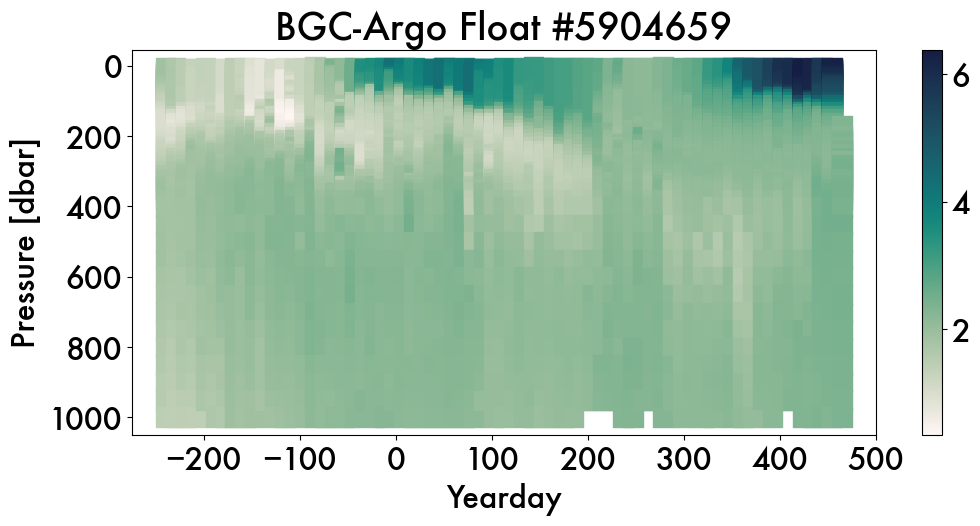

In [657]:
# singple float plot
# float_4659['nprof'] = float_4659.index.get_level_values('N_PROF') 
# float_4659.CT.plot()

fig = plt.figure(figsize=(12,5))
plt.scatter(float_4659.yearday, float_4659.pressure, c=float_4659.CT, cmap=cmo.tempo, s=200, marker='s')
ax=plt.gca()
ax.invert_yaxis()
ax.set_title('BGC-Argo Float #5904659')
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
plt.colorbar()


- 5906032, 5904854, 5906206, 5904845, 5905135 removed for high temperatures / too high latitude

# 4.0 Remove floats and save

<!-- - 7900907, 7900915, 7900918 removed for yearday
- 5906034, 5906033, 5906210, 5906211 removed for too low latitude
- 5906032, 5904854, 5906206, 5904845, 5905135 removed for high temperatures / too high latitude
- 5904847 spatial blocking 

[7900907, 7900915, 7900918, 
                   5906034, 5906033, 5906210, 5906211,
                   5906032, 5904854, 5906206, 5904845, 5905135, 
                   5904847]  -->

sep 17
- 7900907 removed for yearday
- 5906032, 5905135, 5904854, 5904845 removed for high temperatures / too high latitude


NameError: name 'argo_final' is not defined

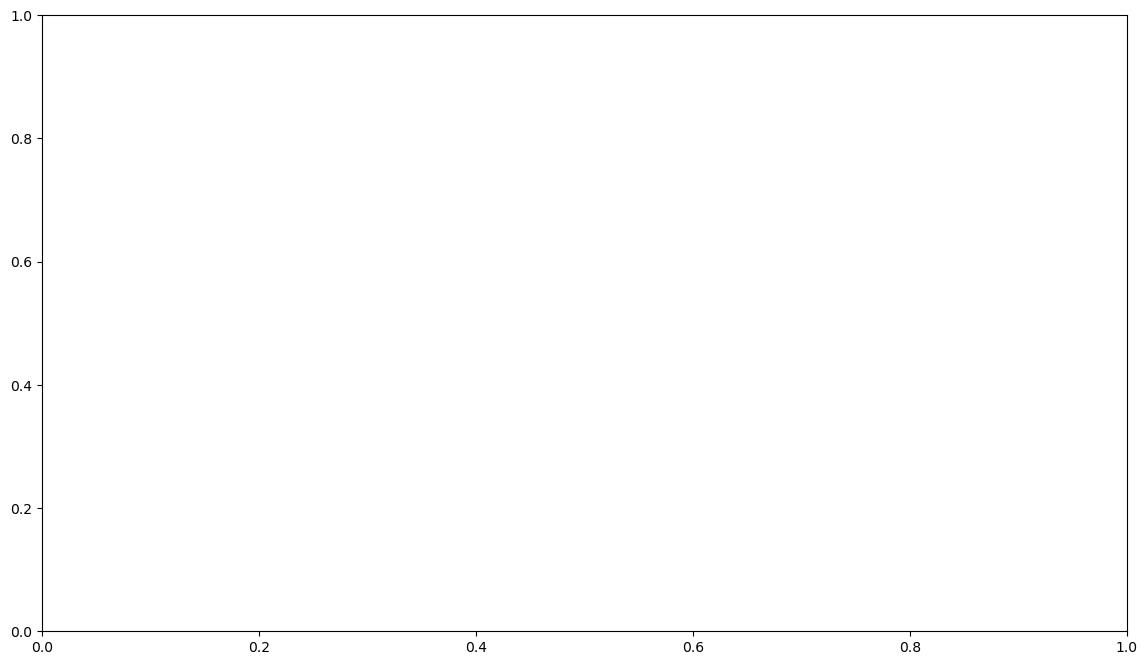

In [168]:
# Reference: Full matchup map for floats, so we can see where the holdout floats are
fig = plt.figure(figsize=(14,8))
ax=plt.gca()

for wmo in wmoids:
    if wmo!=5906030:
        ax.plot(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
                color = wmo_colors[wmo], alpha=0.2, linewidth=5, label=str(wmo)[3:], zorder=3)
        ax.scatter(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
                color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.4, linewidth=7, label=str(wmo)[3:], zorder=3)
    ax.scatter(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)

plt.title('SOGOS BGC-Argo Matchups (2017-2021)')
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.25,linewidth=2, zorder=1)


# ax.legend()
ax.add_patch(rect)
ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=18, zorder=3)
# labelLines(lins) # , align=False, fontsize=18)
# plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)

# Plot Comparisons with Ship, Glider

NameError: name 'df_659' is not defined

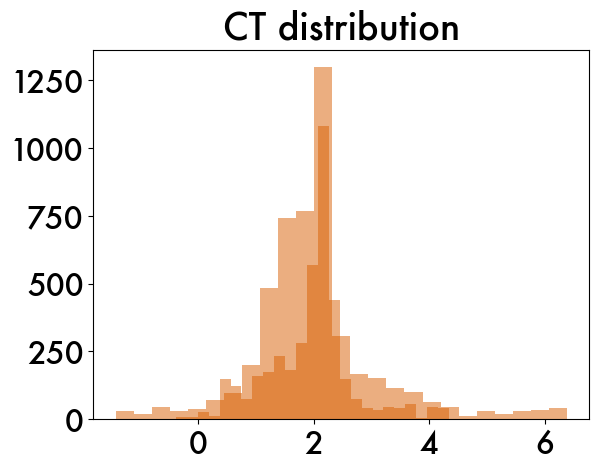

In [84]:
# Compare distributions of two floats and a glider
argofloat = argo_qc[argo_qc.wmoid==5906030]
plt.hist(argofloat.CT, bins=25, color=wmo_colors[5906030], alpha=0.5, label="5906030")
plt.title('CT distribution')

argofloat = argo_qc[argo_qc.wmoid==5904659]
plt.hist(argofloat.CT, bins=25, color=wmo_colors[5904659], alpha=0.5, label="5904659")

# bad_6032 = badtemp[badtemp.wmoid==5906032]
# bad_6032.describe()
# plt.hist(bad_6032.CT, bins=25, color=wmo_colors[5906032], alpha=0.5, label="5906032")


plt.hist(df_659.CT.iloc[200:70000:40], bins=25, color='k', alpha=0.8, label="glider (subset)")
plt.legend()

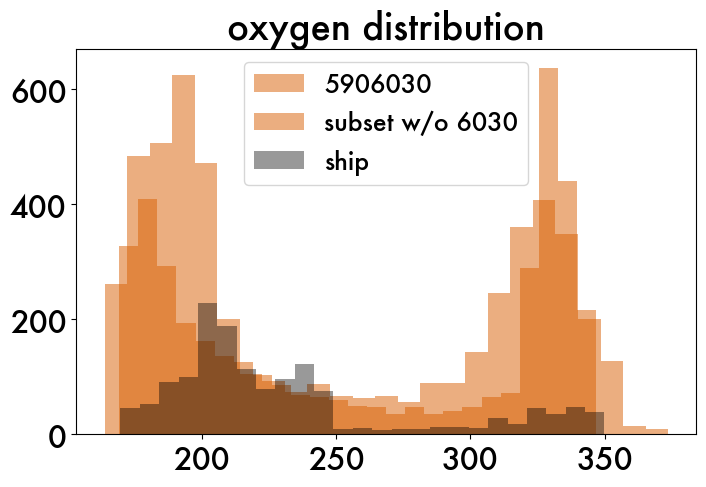

In [88]:
# compare float 6030 with rest of floats, and the ship
fig = plt.figure(figsize=(8,5))

argofloat = argo_final[argo_final.wmoid==5906030]
plt.hist(argofloat.oxygen, bins=25, color=wmo_colors[5906030], alpha=0.5, label="5906030")
plt.title('oxygen distribution')

argofloat = argo_final[argo_final.wmoid!=5906030][0::10]
plt.hist(argofloat.oxygen, bins=25, color=wmo_colors[5904659], alpha=0.5, label="subset w/o 6030")

plt.hist(shipDF.oxygen, bins=25, color='k', alpha=0.4, label="ship")
# plt.hist(df_659.oxygen[200:70000:40], bins=25, color='k', alpha=0.8, label="glider (subset)")

plt.legend()

In [89]:
# compare 6032 with others
fig = plt.figure(figsize=(8,5))
argofloat = argo_qc[argo_qc.wmoid==5906032]
plt.hist(argofloat.nitrate, bins=25, color=wmo_colors[5906032], alpha=0.5, label="5906032")
plt.title('nitrate distribution')

argofloat = argo_qc[argo_qc.wmoid!=5906032][0::10]
plt.hist(argofloat.nitrate, bins=25, color=wmo_colors[5904659], alpha=0.7, label="subset w/o 6032")

plt.hist(shipDF.nitrate, bins=25, color='k', alpha=0.4, label="ship")

# plt.hist(df_659.nitrate[200:70000:40], bins=25, color='k', alpha=0.9, label="glider (subset)")

plt.legend()

KeyError: 5906032

<Figure size 800x500 with 0 Axes>

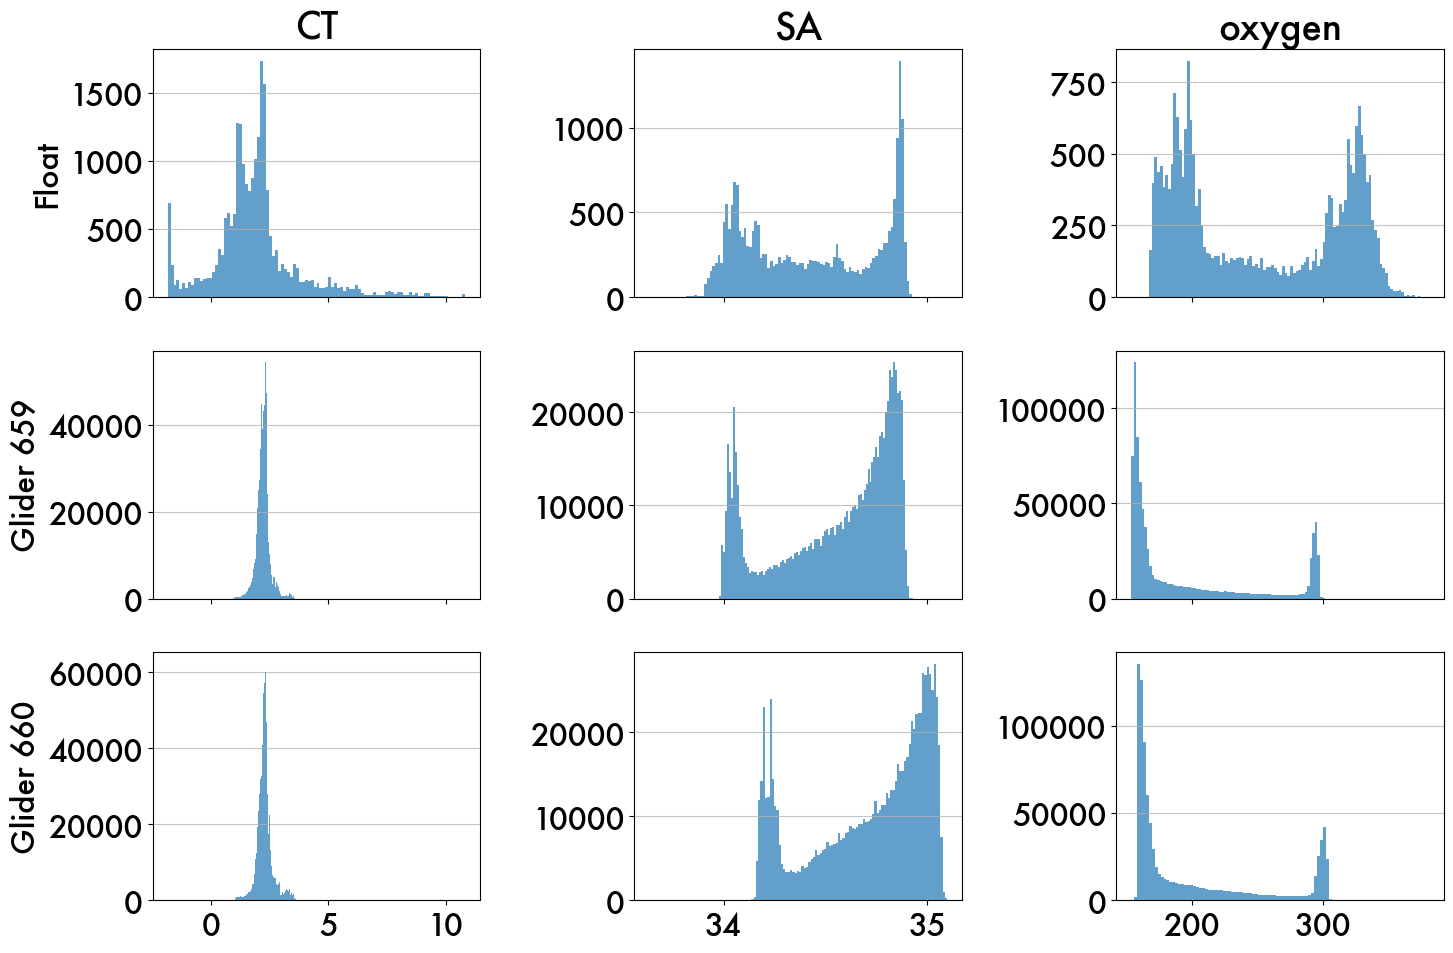

In [24]:
# Variable distributions from training ship/float data before dropping floats
nbins = 100
fig, axs = plt.subplots(3, 3, figsize=(15, 10), tight_layout=True, sharex='col')
for c, var in enumerate(['CT', 'SA', 'oxygen']):
    axs[0,c].hist(x=argo_final[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Float')
axs[1,0].set_ylabel('Glider 659')
axs[2,0].set_ylabel('Glider 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)


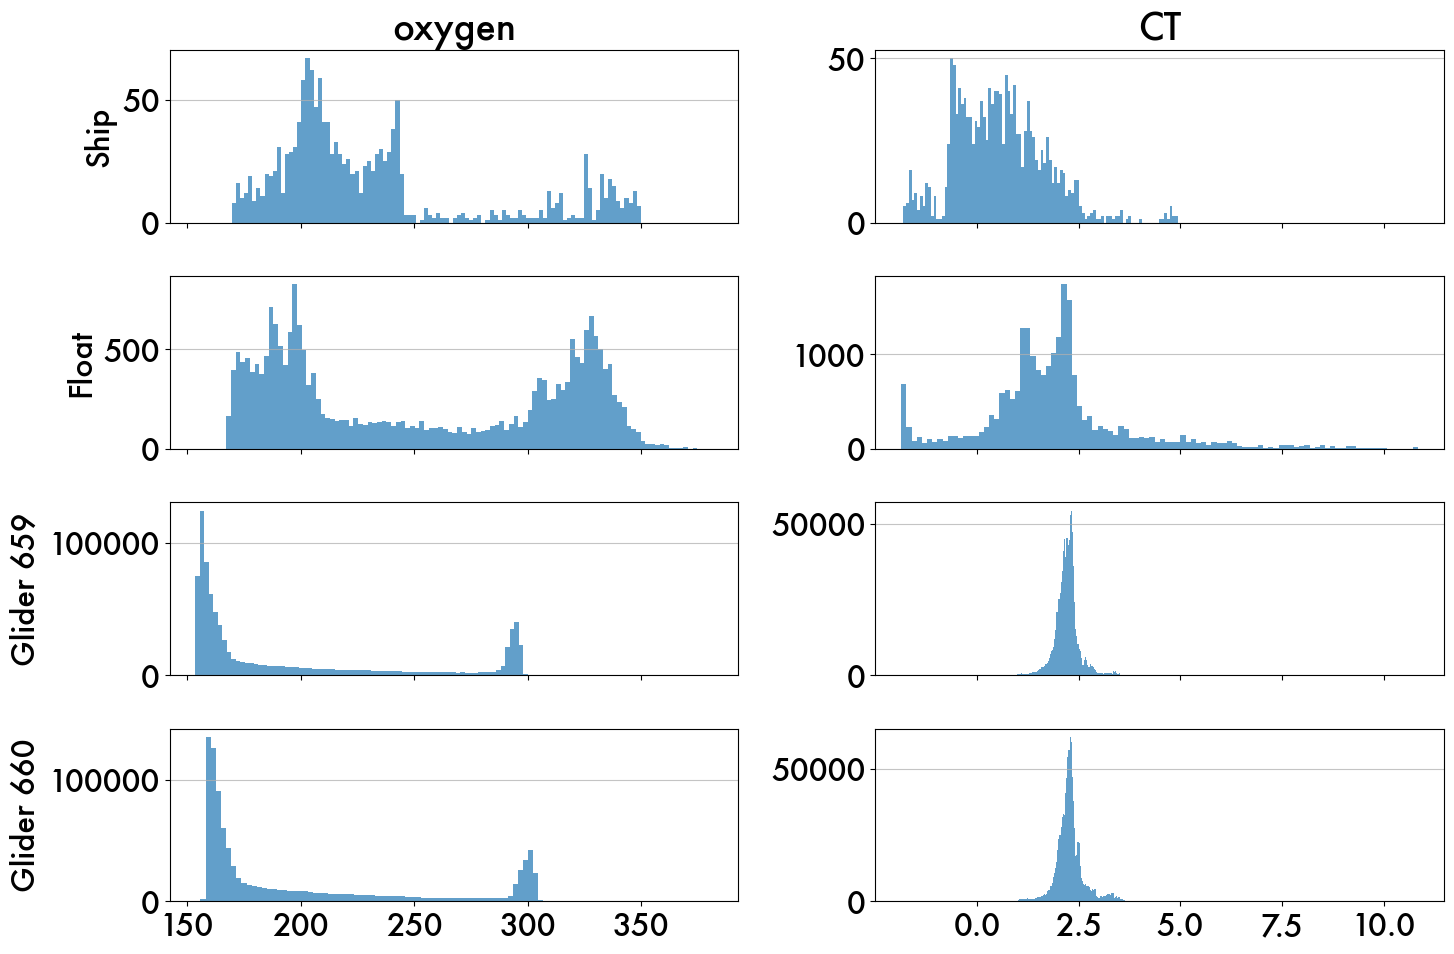

In [30]:
# Variable distributions from training ship/float data 
nbins = 100
fig, axs = plt.subplots(4, 2, figsize=(15, 10), tight_layout=True, sharex='col')
for c, var in enumerate(['oxygen', 'CT']):
    axs[0,c].hist(x=shipDF[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=argo_final[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[3,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Ship')
axs[1,0].set_ylabel('Float')
axs[2,0].set_ylabel('Glider 659')
axs[3,0].set_ylabel('Glider 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)

In [144]:
file_path = '../working-vars/nitrate-prediction/'
df_659 = pd.read_csv(file_path + 'RFpred_659_standard_n1000_third_0914.csv', index_col=0)
df_660 = pd.read_csv(file_path + 'RFpred_660_standard_n1000_third_0914.csv', index_col=0)

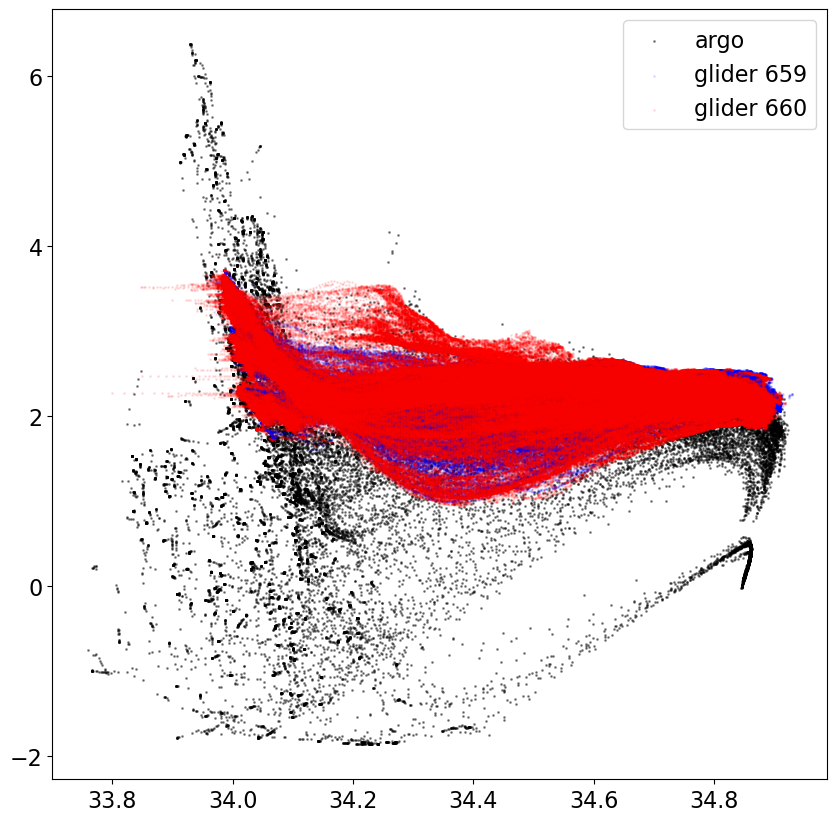

In [145]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
plt.scatter(argo_qc.SA, argo_qc.CT, c='k', alpha=0.4, s=1, label='argo')
plt.scatter(df_659.SA, df_659.CT, c='b', alpha=0.1, s=1,label='glider 659')
plt.scatter(df_660.SA, df_660.CT, c='r', alpha=0.1, s=1,label='glider 660')
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'N_PROF'

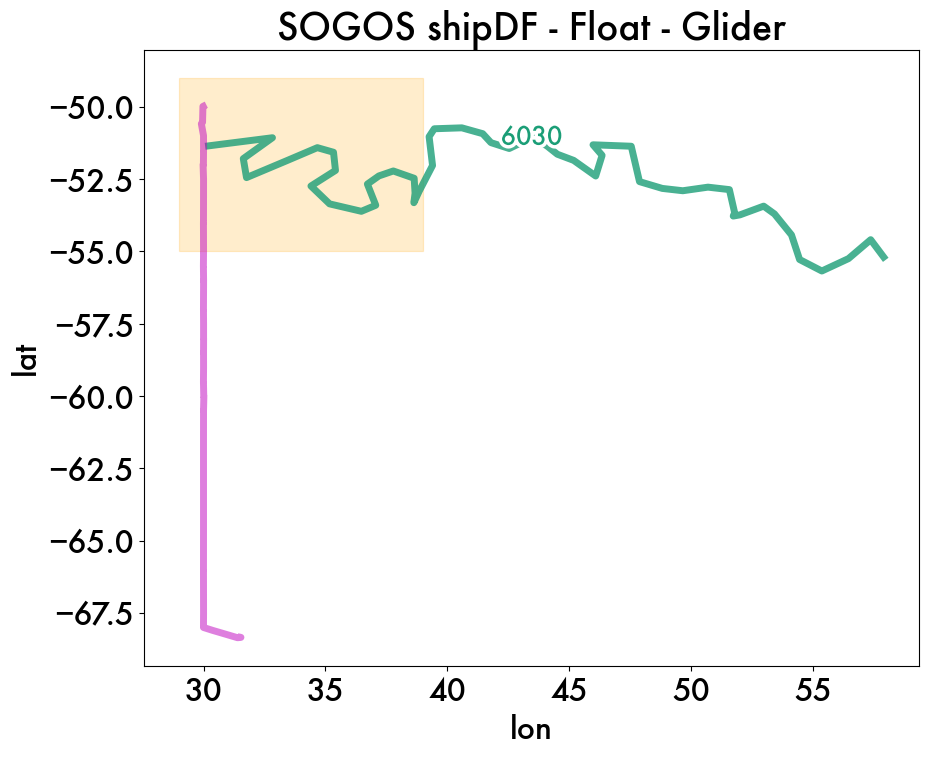

In [64]:
# Simple SOGOS -- single 6030, glider region, shipDF track

dav_659=dav_659.where(dav_659.dive<480, drop=True)
dav_660=dav_660.where(dav_660.dive<480, drop=True)
# check where floats are
fig = plt.figure(figsize=(10,8))
pal = sns.color_palette("Dark2")
sns.set_palette(pal)

# for wmo in wmo_qc:
for wmo in [5906030]:
    plt.plot(argo_data[argo_data.wmoid==wmo].lon,argo_data[argo_data.wmoid==wmo].lat, label=str(wmo)[3:], linewidth=5, alpha=0.8)
    
# plt.legend()
plt.title('SOGOS shipDF - Float - Glider')
rect = patch.Rectangle((29,-55),10,6,fill=True,color="orange", alpha=0.2,linewidth=0.9)

ax=plt.gca()
ax.add_patch(rect)
# ax.set_xlim(0,50)
ax.set_xlabel('lon')
# ax.set_ylim(-60,-30)
ax.set_ylabel('lat')

# 590603
labelLines(ax.get_lines(), align=False, fontsize=18)


# plt.scatter(shipDF.lon, shipDF.lat, c='k', s=8)
plt.plot(shipDF.lon, shipDF.lat, alpha=0.5, c='m', linewidth=5)

for nprof in shipDF.N_PROF.values[10::10]:
    plt.scatter(shipDF.lon[shipDF.N_PROF == nprof], shipDF.lat[shipDF.N_PROF == nprof], c='m', s=56)  
    plt.text(shipDF.lon[shipDF.N_PROF == nprof]+1, shipDF.lat[shipDF.N_PROF == nprof]-1, ('stn ' + str(nprof)), c='m', fontsize=18)  


plt.plot(dav_659.lon, dav_659.lat, c='k', linewidth=4)
# plt.plot(dav_660.lon, dav_660.lat, c='k', linewidth=3)

# ESPER Comparison

In [178]:
# First need to save the right dataset for import into MATLAB.
sogos_ind = np.where(argo_qc.wmoid==5906030)
df = argo_qc.iloc[sogos_ind] 

dict = {"temp": df.temperature.values, 
    "sal": df.salinity.values, 
    "oxygen": df.oxygen.values, 
    "depth": df.pressure.values,
    "lat": df.lat.values, 
    "lon": df.lon.values}

scipy.io.savemat('/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/nitrate-prediction/sgfloat_for_ESPER_0601.mat', dict)
